# Data preparation

The dataset, as extracted by our query from GraphDB, needs some minor patching to fix some issues related to bad format.

In [1]:
# !cat query-result.tsv | sed 's/View\\"/View/g' > fixed.tsv
# !cat fixed.tsv | sed 's/“Eduardo R. Caianiello\\"/“Eduardo R. Caianiello”/g' > fixed2.tsv
# !rm fixed.tsv
# !mv fixed2.tsv query-result.tsv

In [2]:
import collections
import numpy as np

import pandas as pd
from pandas import DataFrame, read_csv

import plotly
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio

import matplotlib.pyplot as plt
import scipy
import scipy.stats
from scipy.optimize import leastsq
from scipy.stats import spearmanr
from scipy.stats import pearsonr

import pycountry_convert

# plotly.offline.init_notebook_mode()
init_notebook_mode(connected=True)

pd.set_option('display.max_columns', None)

In [110]:
df = read_csv('./query-result.tsv', delimiter='\t', dtype=object)
newcols = {
    '?paper_doi': 'paper_doi',
    '?conf_id': 'conf_id',
    '?conf_seriesId': 'conf_seriesId',
    '?conf_acronym': 'conf_acronym',
    '?conf_name': 'conf_name',
    '?conf_country': 'conf_country',
    '?conf_city': 'conf_city',
    '?author_order': 'author_order', 
    '?author_givenName': 'author_givenName',
    '?author_familyName': 'author_familyName',
    '?org_gridId': 'org_gridId',
    '?org_name': 'org_name',
    '?org_city': 'org_city',
    '?org_country': 'org_country',
    '?org_countrycode': 'org_countrycode',
    '?affiliationString': 'affiliation_string',
    '?paper_title': 'paper_title',
    '?book_doi': 'book_doi',
    '?book_title': 'book_title',
    '?book_subtitle': 'book_confSubtitle',
    '?rights': 'rights',
    '?year': 'year'
}
df.rename(columns=newcols, inplace=True)
df['year'] = df['year'].str.replace(r'\^\^<http://www.w3.org/2001/XMLSchema#gYear>', '')
df['year'] = pd.to_datetime(df['year'], format="%Y")
df['author_order'] = pd.to_numeric(df['author_order'])
df.head()

,paper_doi,conf_id,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliation_string,paper_title,book_doi,book_title,book_confSubtitle,rights,year
0,10.1007/11678564_14,a462e5448db3b48f8ab0b392a20e4516,bpm,BPM,International Conference on Business Process M...,Nancy,France,1,Malu,Castellanos,grid.418547.b,Hewlett-Packard (United States),Palo Alto,United States,US,Hewlett-Packard Labs,Preface (BPI 2005),10.1007/11678564,Business Process Management Workshops,"BPM 2005 International Workshops, BPI, BPD, EN...",Restricted,2006-01-01
1,10.1007/11678564_14,a462e5448db3b48f8ab0b392a20e4516,bpm,BPM,International Conference on Business Process M...,Nancy,France,2,Ton,Weijters,NaN,NaN,NaN,NaN,NaN,U. of Eindhoven,Preface (BPI 2005),10.1007/11678564,Business Process Management Workshops,"BPM 2005 International Workshops, BPI, BPD, EN...",Restricted,2006-01-01
2,10.1007/11678564_16,a462e5448db3b48f8ab0b392a20e4516,bpm,BPM,International Conference on Business Process M...,Nancy,France,1,Linh Thao,Ly,grid.6582.9,University of Ulm,Ulm,Germany,DE,University of Ulm,Mining Staff Assignment Rules from Event-Based...,10.1007/11678564,Business Process Management Workshops,"BPM 2005 International Workshops, BPI, BPD, EN...",Restricted,2006-01-01
3,10.1007/11678564_16,a462e5448db3b48f8ab0b392a20e4516,bpm,BPM,International Conference on Business Process M...,Nancy,France,2,Stefanie,Rinderle,grid.6582.9,University of Ulm,Ulm,Germany,DE,University of Ulm,Mining Staff Assignment Rules from Event-Based...,10.1007/11678564,Business Process Management Workshops,"BPM 2005 International Workshops, BPI, BPD, EN...",Restricted,2006-01-01
4,10.1007/11678564_16,a462e5448db3b48f8ab0b392a20e4516,bpm,BPM,International Conference on Business Process M...,Nancy,France,3,Peter,Dadam,grid.6582.9,University of Ulm,Ulm,Germany,DE,University of Ulm,Mining Staff Assignment Rules from Event-Based...,10.1007/11678564,Business Process Management Workshops,"BPM 2005 International Workshops, BPI, BPD, EN...",Restricted,2006-01-01


In [4]:
# for col in (df.columns):
#     if col != 'year':
#         print(df[df[col].str.contains("w3.org", na = False)])

Let's explore all contributions for a couple of papers

In [114]:
df[df.paper_title == 'NIF Combinator: Combining NLP Tool Output']

,paper_doi,conf_id,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliation_string,paper_title,book_doi,book_title,book_confSubtitle,rights,year
583487,10.1007/978-3-642-33876-2_44,80f10d491a601c62fd8f2d6822a910d4,ekaw,EKAW,International Conference on Knowledge Engineer...,Galway,Ireland,1,Sebastian,Hellmann,grid.9647.c,Leipzig University,Leipzig,Germany,DE,Universität Leipzig,NIF Combinator: Combining NLP Tool Output,10.1007/978-3-642-33876-2,Knowledge Engineering and Knowledge Management,"18th International Conference, EKAW 2012, Galw...",Restricted,2012-01-01
583488,10.1007/978-3-642-33876-2_44,80f10d491a601c62fd8f2d6822a910d4,ekaw,EKAW,International Conference on Knowledge Engineer...,Galway,Ireland,2,Jens,Lehmann,grid.9647.c,Leipzig University,Leipzig,Germany,DE,Universität Leipzig,NIF Combinator: Combining NLP Tool Output,10.1007/978-3-642-33876-2,Knowledge Engineering and Knowledge Management,"18th International Conference, EKAW 2012, Galw...",Restricted,2012-01-01
583489,10.1007/978-3-642-33876-2_44,80f10d491a601c62fd8f2d6822a910d4,ekaw,EKAW,International Conference on Knowledge Engineer...,Galway,Ireland,3,Sören,Auer,grid.6810.f,Chemnitz University of Technology,Chemnitz,Germany,DE,Technische Universität Chemnitz,NIF Combinator: Combining NLP Tool Output,10.1007/978-3-642-33876-2,Knowledge Engineering and Knowledge Management,"18th International Conference, EKAW 2012, Galw...",Restricted,2012-01-01
583490,10.1007/978-3-642-33876-2_44,80f10d491a601c62fd8f2d6822a910d4,ekaw,EKAW,International Conference on Knowledge Engineer...,Galway,Ireland,4,Marcus,Nitzschke,grid.9647.c,Leipzig University,Leipzig,Germany,DE,Universität Leipzig,NIF Combinator: Combining NLP Tool Output,10.1007/978-3-642-33876-2,Knowledge Engineering and Knowledge Management,"18th International Conference, EKAW 2012, Galw...",Restricted,2012-01-01


In [115]:
df[df.paper_doi == '10.1007/11926078_68']

,paper_doi,conf_id,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliation_string,paper_title,book_doi,book_title,book_confSubtitle,rights,year
1760120,10.1007/11926078_68,b02ea6fdadf64adbc6d95ddb5dca530b,semweb,ISWC,International Semantic Web Conference,"Athens, GA",USA,1,Markus,Krötzsch,grid.7892.4,Karlsruhe Institute of Technology,Karlsruhe,Germany,DE,"AIFB, Universität Karlsruhe",Semantic MediaWiki,10.1007/11926078,The Semantic Web - ISWC 2006,"5th International Semantic Web Conference, ISW...",OpenAccess,2006-01-01
1760121,10.1007/11926078_68,b02ea6fdadf64adbc6d95ddb5dca530b,semweb,ISWC,International Semantic Web Conference,"Athens, GA",USA,2,Denny,Vrandečić,grid.7892.4,Karlsruhe Institute of Technology,Karlsruhe,Germany,DE,"AIFB, Universität Karlsruhe",Semantic MediaWiki,10.1007/11926078,The Semantic Web - ISWC 2006,"5th International Semantic Web Conference, ISW...",OpenAccess,2006-01-01
1760122,10.1007/11926078_68,b02ea6fdadf64adbc6d95ddb5dca530b,semweb,ISWC,International Semantic Web Conference,"Athens, GA",USA,3,Max,Völkel,NaN,NaN,NaN,NaN,NaN,FZI Karlsruhe,Semantic MediaWiki,10.1007/11926078,The Semantic Web - ISWC 2006,"5th International Semantic Web Conference, ISW...",OpenAccess,2006-01-01


In [112]:
df[(df.affiliation_string == 'University of Oxford') & (df.org_countrycode == 'IL')]

,paper_doi,conf_id,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliation_string,paper_title,book_doi,book_title,book_confSubtitle,rights,year
1393283,10.1007/0-387-25515-X_15,NaN,NaN,NaN,NaN,NaN,NaN,1,Derek J.,Blake,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,Glycosylation Defects and Muscular Dystrophy,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393284,10.1007/0-387-25515-X_15,NaN,NaN,NaN,NaN,NaN,NaN,2,Christopher T.,Esapa,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,Glycosylation Defects and Muscular Dystrophy,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393297,10.1007/0-387-25515-X_18,NaN,NaN,NaN,NaN,NaN,NaN,1,Simon A.,Fry,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,Differential Glycosylation of Gelatinase B fro...,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393299,10.1007/0-387-25515-X_18,NaN,NaN,NaN,NaN,NaN,NaN,3,Louise,Royle,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,Differential Glycosylation of Gelatinase B fro...,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393300,10.1007/0-387-25515-X_18,NaN,NaN,NaN,NaN,NaN,NaN,4,Mark R.,Wormald,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,Differential Glycosylation of Gelatinase B fro...,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393303,10.1007/0-387-25515-X_18,NaN,NaN,NaN,NaN,NaN,NaN,7,Pauline M.,Rudd,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,Differential Glycosylation of Gelatinase B fro...,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393304,10.1007/0-387-25515-X_18,NaN,NaN,NaN,NaN,NaN,NaN,8,Raymond A.,Dwek,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,Differential Glycosylation of Gelatinase B fro...,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393305,10.1007/0-387-25515-X_21,NaN,NaN,NaN,NaN,NaN,NaN,1,Frances M.,Platt,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,New Developments in Treating Glycosphingolipid...,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393306,10.1007/0-387-25515-X_21,NaN,NaN,NaN,NaN,NaN,NaN,2,Mylvaganam,Jeyakumar,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,New Developments in Treating Glycosphingolipid...,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01
1393307,10.1007/0-387-25515-X_21,NaN,NaN,NaN,NaN,NaN,NaN,3,Ulrika,Andersson,grid.13992.30,Weizmann Institute of Science,Rehovot,Israel,IL,University of Oxford,New Developments in Treating Glycosphingolipid...,10.1007/b135491,Glycobiology and Medicine,Proceedings of the 7th Jenner Glycobiology and...,Restricted,2005-01-01


In [6]:
df.describe(include='all')

,paper_doi,conf_id,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
count,1770091,999822,999822,999822,999822,999822,999822,1.770091e+06,1767514,1770091,1356666,1356666,1356666,1356666,1356632,1737513,1770091,1770091,1770091,1770091,1503426,1770091
unique,506049,1028,977,1074,1213,1244,103,NaN,165052,247568,14802,14623,4203,160,159,191164,503994,12117,7130,11806,2,22
top,10.1007/978-3-540-49676-2_4,7a0232d303c8198116d174007f5faca1,hci,MICCAI,International Conference on Medical Image Comp...,Beijing,China,NaN,M.,Wang,grid.9227.e,Chinese Academy of Sciences,Beijing,China,CN,Chinese Academy of Sciences,Introduction,10.1007/978-3-540-36841-0,World Congress on Medical Physics and Biomedic...,Volume 1,Restricted,2015-01-01 00:00:00
freq,240,27468,38971,21475,21475,26828,129061,NaN,20176,25630,10536,10536,54835,193013,193013,9222,409,5240,12404,7924,1428271,149612
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:00
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.647722e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.638346e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Macro analysis

In [8]:
def country_to_countrycode(country):
    if pd.isna(country) is not True:
        return pycountry_convert.country_name_to_country_alpha2(country)
    else:
        return None
    
def countrycode_to_continent(country_code):
    if pd.isna(country_code) is not True:
        return pycountry_convert.country_alpha2_to_continent_code(country_code)
    else:
        return None

In [9]:
macro = df[df.year != '2017-01-01']
macro.conf_country.replace(to_replace={'The Netherlands': 'Netherlands',
                                       'UK': 'United Kingdom', 
                                       'Korea (Republic of)': 'South Korea'}, inplace=True)

/Users/andrea/.virtualenvs/skm/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [116]:
macro[['conf_countrycode', 'conf_continent', 'org_continent']] = macro.apply(lambda row: [country_to_countrycode(row['conf_country']),
                                                                                          countrycode_to_continent(country_to_countrycode(row['conf_country'])),
                                                                                          countrycode_to_continent(row['org_countrycode'])],
                                                                                          axis=1, result_type='expand')

In [117]:
macro.describe(include='all')

,paper_doi,conf_id,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year,conf_countrycode,conf_continent,org_continent
count,1664733,946165,946165,946165,946165,946165,946165,1.664733e+06,1663075,1664733,1342508,1342508,1342508,1342508,1342474,1632282,1664733,1664733,1664733,1664733,1398076,1664733,946165,946165,1342474
unique,477921,1016,969,1064,1193,1201,100,NaN,157022,235440,14720,14542,4188,160,159,182169,475894,11335,6726,11056,2,21,100,6,6
top,10.1007/978-3-540-49676-2_9,7a0232d303c8198116d174007f5faca1,hci,MICCAI,International Conference on Medical Image Comp...,Beijing,China,NaN,M.,Wang,grid.9227.e,Chinese Academy of Sciences,Beijing,China,CN,Chinese Academy of Sciences,Introduction,10.1007/978-3-540-36841-0,World Congress on Medical Physics and Biomedic...,Volume 1,Restricted,2015-01-01 00:00:00,CN,EU,EU
freq,240,27468,34390,19683,19683,25829,124473,NaN,19506,24014,10519,10519,54527,191184,191184,8792,392,5240,12404,7605,1324725,149612,124473,515033,630911
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-01-01 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.646140e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.676850e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
author_lists = macro[['paper_doi', 'author_order', 'author_familyName']].drop_duplicates().sort_values(by=['paper_doi', 'author_order'])
author_lists = author_lists.groupby('paper_doi').agg({'author_familyName':lambda x: list(x)})

In [13]:
author_lists = macro[['paper_doi', 'author_order', 'author_familyName']].drop_duplicates().sort_values(by=['paper_doi', 'author_order'])
author_lists = author_lists.groupby('paper_doi').agg({'author_familyName':lambda x: list(x)})

def isOrdered(l):
    if len(l) == 1:
        return False
    else:
        return all(l[i] <= l[i+1] for i in range(len(l)-1))
    
author_lists['isOrdered'] = author_lists.apply(lambda row: isOrdered(row['author_familyName']), axis=1)
author_lists['n_authors'] = author_lists.apply(lambda row: len(row['author_familyName']), axis=1)

In [14]:
author_lists.head(n=10)

,author_familyName,isOrdered,n_authors
paper_doi,,,
10.1007/0-387-25515-X_1,"[Zitzmann, Block, Methta, Rudd, Burton, Wilson...",False,9
10.1007/0-387-25515-X_10,"[Steen, Grillet, Opdenakker]",False,3
10.1007/0-387-25515-X_11,"[Wright, Day]",False,2
10.1007/0-387-25515-X_12,"[Shore, Wilson, Dwek, Rudd]",False,4
10.1007/0-387-25515-X_13,"[Mimura, Golgher, Mimura-Kimura, Dwek, Rudd, E...",False,6
10.1007/0-387-25515-X_14,[Hooper],False,1
10.1007/0-387-25515-X_15,"[Blake, Esapa, Martin-Rendon, McIlhinney]",True,4
10.1007/0-387-25515-X_16,"[Shi, Williams, Kurniawan, Lu, Stanley]",False,5
10.1007/0-387-25515-X_17,"[Baldwin, Allen, Bourke, Hounsell, Calvert]",False,5


In [15]:
author_lists[(author_lists.isOrdered == True)].shape[0]/author_lists.shape[0]

0.26809661010920216

In [16]:
author_lists[(author_lists.isOrdered == True) & (author_lists.n_authors >= 3)].shape[0]/author_lists.shape[0]

0.1125311505458015

In [17]:
trace = go.Histogram(x=author_lists[(author_lists.isOrdered == True)]['n_authors'], 
                     histnorm='probability',
                     xbins=dict(start=1,
                                size=1,
                                end=np.max(author_lists[(author_lists.isOrdered == True)]['n_authors'])))

layout = go.Layout(title="Probability distribution of n_authors for authors ordered alphabetically")

fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)

In [18]:
macro_first = macro[macro.author_order == 1]
macro_last_authors_idx = macro.groupby('paper_doi')['author_order'].transform(max) == macro['author_order']
macro_last = macro[macro_last_authors_idx]

In [19]:
macro_last_authors = macro_last[['author_familyName', 'author_givenName', 'paper_doi']].groupby(['author_familyName', 'author_givenName']).count().sort_values(by=['paper_doi'], ascending=False).reset_index()
macro_last_authors.head(n=10)

,author_familyName,author_givenName,paper_doi
0,Shen,Dinggang,213
1,Moore,Jason H.,201
2,Zhang,Mengjie,173
3,Navab,Nassir,168
4,Słowiński,Roman,143
5,Krcmar,Helmut,136
6,Preneel,Bart,135
7,Tanaka,Katsumi,131
8,Yung,Moti,127
9,Janssen,Marijn,127


In [20]:
trace1 = go.Scatter(x=macro.groupby('year')['conf_id'].nunique().index,
                    y=macro.groupby('year')['conf_id'].nunique().values,
                    name='conferences')

layout = go.Layout(title=" [Macro] Number of conferences per year",
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1], layout=layout)
plotly.offline.iplot(fig)

In [21]:
macro_contributions = macro.groupby(['year'])['paper_doi'].count()
macro_contributions_with_gridId = macro[macro['org_gridId'].notna()].groupby(['year'])['paper_doi'].count()
macro_contributions_without_gridId = macro[macro['org_gridId'].isna()].groupby(['year'])['paper_doi'].count()

trace1 = go.Scatter(x=macro_contributions.index,
                    y=macro_contributions.values,
                    name='contributions',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=macro_contributions_with_gridId.index,
                    y=macro_contributions_with_gridId.values,
                    name='contributions (with gridID)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=macro_contributions_without_gridId.index,
                    y=macro_contributions_without_gridId.values,
                    name='contributions (without gridID)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')
                    
layout = go.Layout(title='Trends of contributions',
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)

In [22]:
macro_ids = macro.groupby(['year'])['paper_doi', 'org_gridId'].nunique()

trace1 = go.Scatter(x=macro_ids.index,
                    y=macro_ids['paper_doi'],
                    name='DOIs',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=macro_ids.index,
                    y=macro_ids['org_gridId'],
                    name='gridIDs',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

layout = go.Layout(title='Trends of unique identifiers',
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1, trace2], layout=layout)
plotly.offline.iplot(fig)

In [23]:
macro_ids.corr()

,paper_doi,org_gridId
paper_doi,1.000000,0.987483
org_gridId,0.987483,1.000000


In [24]:
macro_gridId = macro.groupby(['year'])['org_gridId'].nunique()
macro_gridId_first = macro_first.groupby(['year'])['org_gridId'].nunique()
macro_gridId_last = macro_last.groupby(['year'])['org_gridId'].nunique()
macro_gridId_diff = macro_gridId - pd.concat([macro_gridId_first, macro_gridId_last], axis=1).mean(axis=1)

trace1 = go.Scatter(x=macro_gridId.index,
                    y=macro_gridId.values,
                    name='gridIDs',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=macro_gridId_first.index,
                    y=macro_gridId_first.values,
                    name='gridIDs (first authors)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=macro_gridId_last.index,
                    y=macro_gridId_last.values,
                    name='gridIDs (last authors)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')

trace4 = go.Scatter(x=macro_gridId_diff.index,
                    y=macro_gridId_diff.values,
                    name='differential trend')

layout = go.Layout(title='gridIDs breakdown by author position',
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
plotly.offline.iplot(fig)

In [25]:
macro_authors = macro_last[['year', 'paper_doi', 'author_order']]
macro_authors['author_order'] = pd.to_numeric(macro_authors['author_order'], errors='raise')
macro_authors.drop_duplicates().groupby(['year']).describe()

/Users/andrea/.virtualenvs/skm/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



author_order                                               
                  count      mean       std  min  25%  50%  75%    max
year                                                                  
1996-01-01       7054.0  2.946130  2.423991  1.0  1.0  2.0  4.0   42.0
1997-01-01       6465.0  2.708739  2.597438  1.0  1.0  2.0  3.0   82.0
1998-01-01       7817.0  3.005629  2.416617  1.0  1.0  2.0  4.0   58.0
1999-01-01       8364.0  2.675395  2.387983  1.0  1.0  2.0  3.0   65.0
2000-01-01       8472.0  3.009679  2.287639  1.0  1.0  2.0  4.0   48.0
2001-01-01       6987.0  3.073851  3.002144  1.0  1.0  2.0  4.0   98.0
2002-01-01       5492.0  3.243809  2.291001  1.0  2.0  3.0  4.0   38.0
2003-01-01      13299.0  2.979547  2.601329  1.0  2.0  2.0  4.0   47.0
2004-01-01      22017.0  2.859972  1.776319  1.0  2.0  3.0  4.0   53.0
2005-01-01      22318.0  2.914777  1.465070  1.0  2.0  3.0  4.0   30.0
2006-01-01      26350.0  2.987894  1.589048  1.0  2.0  3.0  4.0   34.0
2007-01-01      27211.0  3.254676  2.467779  1.0  2.0  3.0  4.0  105.0
2008-01-01      28319.0  3.161235  1.928427  1.0  2.0  3.0  4.0   71.0
2009-01-01      32167.0  3.195355  1.837288  1.0  2.0  3.0  4.0   48.0
2010-01-01      28860.0  3.118053  1.747068  1.0  2.0  3.0  4.0   43.0
2011-01-01      36287.0  3.065974  1.801817  1.0  2.0  3.0  4.0   84.0
2012-01-01      37344.0  3.123474  1.851557  1.0  2.0  3.0  4.0  102.0
2013-01-01      37473.0  3.179036  1.705797  1.0  2.0  3.0  4.0   41.0
2014-01-01      37574.0  3.304120  1.766172  1.0  2.0  3.0  4.0   43.0
2015-01-01      40814.0  3.262018  1.772413  1.0  2.0  3.0  4.0   57.0
2016-01-01      37237.0  3.324113  2.033499  1.0  2.0  3.0  4.0  139.0

In [26]:
macro_countries = macro.groupby(['year'])['org_country'].nunique()
macro_countries_first = macro_first.groupby(['year'])['org_country'].nunique()
macro_countries_last = macro_last.groupby(['year'])['org_country'].nunique()
macro_countries_diff = macro_countries - pd.concat([macro_countries_first, macro_countries_last], axis=1).mean(axis=1)

trace1 = go.Scatter(x=macro_countries.index,
                    y=macro_countries.values,
                    name='countries',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=macro_countries_first.index,
                    y=macro_countries_first.values,
                    name='countries (first authors)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=macro_countries_last.index,
                    y=macro_countries_last.values,
                    name='gridIDs (last authors)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')

trace4 = go.Scatter(x=macro_countries_diff.index,
                    y=macro_countries_diff.values,
                    name='differential trend')

layout = go.Layout(title='Countries breakdown by author position',
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
plotly.offline.iplot(fig)

In [27]:
macro_dois = macro.groupby(['org_country'])['paper_doi'].nunique().reset_index()
macro_dois_first = macro_first.groupby(['org_country'])['paper_doi'].nunique().reset_index()
macro_dois_last = macro_last.groupby(['org_country'])['paper_doi'].nunique().reset_index()

pie1 = go.Pie(values=macro_dois['paper_doi'],
              labels=macro_dois['org_country'],
              textposition='inside',
              domain=dict(x=[0, 1], y=[.4, 1]),
              name='DOIs',
              hoverinfo='label+value+name',
              hole=.4)

pie2 = go.Pie(values=macro_dois_first['paper_doi'],
              labels=macro_dois_first['org_country'],
              textposition='inside',
              domain=dict(x=[0, .5], y=[0, .6]),
              name='DOIs',
              hoverinfo='label+value+name',
              hole=.4)

pie3 = go.Pie(values=macro_dois_last['paper_doi'],
              labels=macro_dois_last['org_country'],
              textposition='inside',
              domain=dict(x=[.5, 1], y=[0, .6]),
              name='DOIs',
              hoverinfo='label+value+name',
              hole=.4)

layout = go.Layout(title='DOIs breakdown by country',
                   annotations=[dict(font=dict(size=15),
                                    showarrow=False,
                                    text='All authors',
                                    x=.5, y=1.07),
                                dict(font=dict(size=15),
                                    showarrow=False,
                                    text='1st authors',
                                    x=.18, y=-0.07),
                                dict(font=dict(size=15),
                                    showarrow=False,
                                    text='Last authors',
                                    x=.83, y=-0.07)])


fig = go.Figure(data=[pie1,pie2,pie3], layout=layout)
plotly.offline.iplot(fig)

In [28]:
hist = go.Bar(x=macro_dois.sort_values(by=['paper_doi'], ascending=False)['org_country'],
              y=macro_dois.sort_values(by=['paper_doi'], ascending=False)['paper_doi'])

layout = go.Layout(
    title='Paper distribution',
    font=dict(size=14),
    xaxis=dict(tickangle=45)
)

fig = go.Figure(data=[hist], layout=layout)
plotly.offline.iplot(fig)

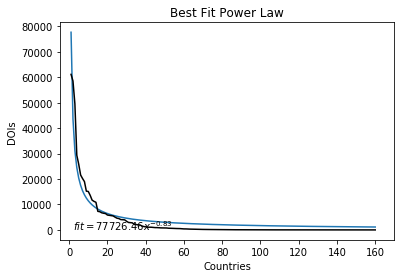

In [29]:
test = macro_dois.sort_values(by=['paper_doi'], ascending=False)
test.insert(0, 'Rank', range(1, 1+len(test)))

x, y = test.Rank, test.paper_doi
powerlaw = lambda x, amp, index: amp * (x**index)

# define the fitting function
fitfunc = lambda p, x: p[0]*(x**p[1])
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0, 0.]
out = leastsq(errfunc, pinit, args=(x, y), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = pfinal[0]

plt.clf()
plt.subplot(1, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.plot(x, y, 'k')  # Data
plt.text(2, 4, '$fit = %5.2fx^{%5.2f}$' % (amp, index))
plt.title('Best Fit Power Law')
plt.xlabel('Countries')
plt.ylabel('DOIs')
plt.xlim(-5, 170)

plt.show()

In [30]:
# Pareto check over years
data = macro.groupby(['year', 'org_country'])['paper_doi'].nunique().reset_index().sort_values(by=['year', 'paper_doi'], ascending=[True, False])
for year in data.year.unique():
    year_data = data[data.year == year]
    n_countries = len(year_data.org_country)
    twenty_n_countries = int(round(0.2 * n_countries))
    n_papers = year_data.paper_doi.sum()
    eighty_n_papers = int(round(0.8 * n_papers))
    observed_n_papers = year_data[:twenty_n_countries].paper_doi.sum()
    is_pareto = True if observed_n_papers >= eighty_n_papers else False
    print('%s\t%s\t%s\t%s\t%s\t%s\t%s'% (year, n_papers, n_countries, twenty_n_countries, eighty_n_papers, observed_n_papers, is_pareto))

1996-01-01T00:00:00.000000000	6170	70	14	4936	5238	True
1997-01-01T00:00:00.000000000	5104	68	14	4083	4287	True
1998-01-01T00:00:00.000000000	6482	75	15	5186	5484	True
1999-01-01T00:00:00.000000000	7447	77	15	5958	6355	True
2000-01-01T00:00:00.000000000	7086	81	16	5669	6045	True
2001-01-01T00:00:00.000000000	6209	68	14	4967	5141	True
2002-01-01T00:00:00.000000000	4953	72	14	3962	4104	True
2003-01-01T00:00:00.000000000	13575	84	17	10860	11185	True
2004-01-01T00:00:00.000000000	22447	100	20	17958	19210	True
2005-01-01T00:00:00.000000000	23920	96	19	19136	20487	True
2006-01-01T00:00:00.000000000	28428	100	20	22742	24210	True
2007-01-01T00:00:00.000000000	27139	106	21	21711	22805	True
2008-01-01T00:00:00.000000000	30218	115	23	24174	25956	True
2009-01-01T00:00:00.000000000	34375	119	24	27500	29781	True
2010-01-01T00:00:00.000000000	31408	114	23	25126	26742	True
2011-01-01T00:00:00.000000000	38355	123	25	30684	33705	True
2012-01-01T00:00:00.000000000	40432	121	24	32346	35284	True
2013-01-01

In [31]:
data = macro.groupby(['year', 'org_country'])['paper_doi'].nunique().reset_index().sort_values(by=['year', 'paper_doi'], ascending=[True, False])

top_n = [5, 10, 25]
for n in top_n:
    previous = []
    coeffs = []
    p_vals = []
    rates_of_change = []
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
#             print('%s\n%s' % (previous.tolist(), current.tolist()))
            changes = len(previous) - len(set(previous) & set(current))
            rate_of_change = changes / len(previous)
#             print(rate_of_change)
            rates_of_change.append(rate_of_change)
            current_rank = []
            for c in current.tolist():
                if c in previous:
                    current_rank.append(previous.tolist().index(c) + 1)
                else:
                    current_rank.append(n+1)
            
            pearson = pearsonr(list(range(1, n+1)), current_rank)
            coeffs.append(pearson[0])
            p_vals.append(pearson[1])
#             print(list(range(1, n+1)), current_rank)
#             print('|---> ', pearson)
            previous = current
#     print(coeffs)
    print('Top-%s average similarity: %s (avg_p=%s)' % (n, sum(coeffs)/len(coeffs), sum(p_vals)/len(p_vals)))
#     print(rates_of_change)
    print('Top-%s average rate of change: %s' % (n, sum(rates_of_change)/len(rates_of_change)))

    
print('\n')

top_n = [5, 10, 25]
for n in top_n:
    previous = []
    country_counter = collections.Counter()
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(previous)
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(current)
            previous = current

    print('top-%s:' % n, len(country_counter), country_counter)

Top-5 average similarity: 0.8584828197526286 (avg_p=0.08608129985065478)
Top-5 average rate of change: 0.10999999999999999
Top-10 average similarity: 0.8855087752470665 (avg_p=0.01416850950663468)
Top-10 average rate of change: 0.09000000000000002
Top-25 average similarity: 0.9362613826019499 (avg_p=3.956483121364442e-09)
Top-25 average rate of change: 0.08000000000000003


top-5: 10 Counter({'United States': 21, 'Germany': 21, 'United Kingdom': 20, 'Japan': 13, 'China': 13, 'Italy': 7, 'India': 4, 'South Korea': 3, 'France': 2, 'Spain': 1})
top-10: 16 Counter({'United States': 21, 'Germany': 21, 'Japan': 21, 'United Kingdom': 21, 'Italy': 21, 'France': 21, 'Spain': 19, 'Canada': 16, 'China': 14, 'Netherlands': 9, 'South Korea': 6, 'India': 6, 'Russia': 4, 'Poland': 4, 'Australia': 3, 'Switzerland': 3})
top-25: 35 Counter({'United States': 21, 'Germany': 21, 'Japan': 21, 'United Kingdom': 21, 'Italy': 21, 'France': 21, 'Netherlands': 21, 'Canada': 21, 'Australia': 21, 'Switzerland': 21

In [32]:
all_countries = set(macro_dois['org_country'].unique().tolist())
first_countries = set(macro_dois_first['org_country'].unique().tolist())
last_countries = set(macro_dois_last['org_country'].unique().tolist())
all_countries - (first_countries | last_countries)

{'Democratic Republic of the Congo', 'Djibouti'}

In [33]:
sorted = macro_dois.sort_values(by=['paper_doi'], ascending=False)
print('Cutoff point: %s' % (0.2 * len(sorted)))
print('Top20: %s' % int(round(0.2 * len(sorted))))
print('Low80: %s' % (len(sorted) - int(round(0.2 * len(sorted)))))

top20 = sorted[:int(round(0.2 * len(sorted)))]['org_country'].tolist()
low80 = sorted[int(round(0.2 * len(sorted))):]['org_country'].tolist()
print(top20)
print(low80)

trend_top20 = macro[macro.org_country.isin(top20)].groupby(['year'])['paper_doi'].nunique()
trend_low80 = macro[macro.org_country.isin(low80)].groupby(['year'])['paper_doi'].nunique()

plotly.offline.iplot({
    "data": [{
        "x": trend_top20.index,
        "y": trend_top20.values,
        "name": 'top20'
    },
    {
        "x": trend_low80.index,
        "y": trend_low80.values,
        "name": 'low80'
    }],
    "layout": {
        "title": "DOIs top20 VS low80"
    }
})

Cutoff point: 32.0
Top20: 32
Low80: 128
['United States', 'China', 'Germany', 'United Kingdom', 'Japan', 'Italy', 'France', 'Spain', 'India', 'South Korea', 'Canada', 'Australia', 'Netherlands', 'Poland', 'Austria', 'Switzerland', 'Brazil', 'Taiwan', 'Portugal', 'Russia', 'Sweden', 'Belgium', 'Greece', 'Czechia', 'Finland', 'Israel', 'Singapore', 'Denmark', 'Malaysia', 'Norway', 'Ireland', 'Mexico']
['Turkey', 'Romania', 'New Zealand', 'Hungary', 'Iran', 'Chile', 'South Africa', 'Slovakia', 'Tunisia', 'Thailand', 'Slovenia', 'Colombia', 'Bulgaria', 'Argentina', 'Saudi Arabia', 'Luxembourg', 'Egypt', 'Ukraine', 'Vietnam', 'Pakistan', 'Estonia', 'Algeria', 'Croatia', 'Serbia', 'Cyprus', 'Lithuania', 'Latvia', 'Cuba', 'Indonesia', 'United Arab Emirates', 'Venezuela', 'Morocco', 'Iceland', 'Bangladesh', 'Belarus', 'Qatar', 'Macao', 'Uruguay', 'Philippines', 'Lebanon', 'Macedonia', 'Jordan', 'Nigeria', 'Peru', 'Kazakhstan', 'Ecuador', 'Malta', 'Kuwait', 'Kenya', 'Oman', 'Moldova', 'Sri Lank

In [34]:
macro_gridIds = macro.groupby(['org_country'])['org_gridId'].nunique().reset_index()
macro_gridIds_first = macro_first.groupby(['org_country'])['org_gridId'].nunique().reset_index()
macro_gridIds_last = macro_last.groupby(['org_country'])['org_gridId'].nunique().reset_index()

pie1 = go.Pie(values=macro_gridIds['org_gridId'],
              labels=macro_gridIds['org_country'],
              textposition='inside',
              domain=dict(x=[0, 1], y=[.4, 1]),
              name='DOIs',
              hoverinfo='label+value+name',
              hole=.4)

pie2 = go.Pie(values=macro_gridIds_first['org_gridId'],
              labels=macro_gridIds_first['org_country'],
              textposition='inside',
              domain=dict(x=[0, .5], y=[0, .6]),
              name='DOIs',
              hoverinfo='label+value+name',
              hole=.4)

pie3 = go.Pie(values=macro_gridIds_last['org_gridId'],
              labels=macro_gridIds_last['org_country'],
              textposition='inside',
              domain=dict(x=[.5, 1], y=[0, .6]),
              name='DOIs',
              hoverinfo='label+value+name',
              hole=.4)

layout = go.Layout(title='gridIDs breakdown by country',
                   annotations=[dict(font=dict(size=15),
                                    showarrow=False,
                                    text='All authors',
                                    x=.5, y=1.07),
                                dict(font=dict(size=15),
                                    showarrow=False,
                                    text='1st authors',
                                    x=.18, y=-0.07),
                                dict(font=dict(size=15),
                                    showarrow=False,
                                    text='Last authors',
                                    x=.83, y=-0.07)])


fig = go.Figure(data=[pie1,pie2,pie3], layout=layout)
plotly.offline.iplot(fig)

In [35]:
data = [
    go.Bar(
        x=macro_gridIds.sort_values(by=['org_gridId'], ascending=False)['org_country'],
        y=macro_gridIds.sort_values(by=['org_gridId'], ascending=False)['org_gridId']
    )
]
layout = go.Layout(
    title='gridIDs distribution',
    font=dict(size=14),
    xaxis=dict(tickangle=45)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

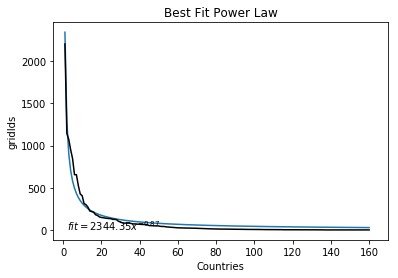

In [36]:
test = macro_gridIds.sort_values(by=['org_gridId'], ascending=False)
test.insert(0, 'Rank', range(1, 1+len(test)))

x, y = test.Rank, test.org_gridId
powerlaw = lambda x, amp, index: amp * (x**index)

# define the fitting function
fitfunc = lambda p, x: p[0]*(x**p[1])
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0, 0.]
out = leastsq(errfunc, pinit, args=(x, y), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = pfinal[0]

plt.clf()
plt.subplot(1, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.plot(x, y, 'k')  # Data
plt.text(2, 4, '$fit = %5.2fx^{%5.2f}$' % (amp, index))
plt.title('Best Fit Power Law')
plt.xlabel('Countries')
plt.ylabel('gridIds')
plt.xlim(-5, 170)

plt.show()

# Micro analysis

## ISWC

### Data preparation

I have to add manually ISWC 2007 and 2015.

In [37]:
iswc = df[(df.conf_seriesId == 'semweb') | (df.book_doi == '10.1007/978-3-540-76298-0') | (df.book_doi == '10.1007/978-3-319-25010-6') | (df.book_doi == '10.1007/978-3-319-25007-6')]
iswc = iswc.fillna({'conf_seriesId': 'semweb', 'conf_acronym': 'ISWC', 'conf_name': 'International Semantic Web Conference'})

iswc.to_csv('iswc_dump.csv')

Manual curation of the dataset is performed on Google Sheets in order to add and resolve missing affiliations.

In [38]:
iswc = read_csv('./iswc_enhanced.csv', dtype=object)
iswc['author_order'] = pd.to_numeric(iswc['author_order'])

In [39]:
iswc.loc[iswc.book_doi == '10.1007/978-3-319-25010-6', 'conf_city'] = 'Bethlehem'
iswc.loc[iswc.book_doi == '10.1007/978-3-319-25010-6', 'conf_country'] = 'United States'

iswc.loc[iswc.book_doi == '10.1007/978-3-319-25007-6', 'conf_city'] = 'Bethlehem'
iswc.loc[iswc.book_doi == '10.1007/978-3-319-25007-6', 'conf_country'] = 'United States'

iswc.loc[iswc.book_doi == '10.1007/978-3-540-76298-0', 'conf_city'] = 'Busan'
iswc.loc[iswc.book_doi == '10.1007/978-3-540-76298-0', 'conf_country'] = 'South Korea'

iswc.loc[iswc.conf_country == 'USA', 'conf_country'] = 'United States'

In [40]:
iswc['conf_acronym'].unique()

array(['ISWC', 'SWSWPC', 'SWDB'], dtype=object)

In [41]:
iswc[iswc.conf_acronym == 'SWSWPC'].head()

,paper_doi,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
154,10.1007/978-3-540-30581-1_4,semweb,SWSWPC,International Workshop on Semantic Web Service...,"San Diego, CA",United States,2,Massimo,Paolucci,grid.147455.6,Carnegie Mellon University,Pittsburgh,United States,US,Carnegie Mellon University,Bringing Semantics to Web Services: The OWL-S ...,10.1007/b105145,Semantic Web Services and Web Process Composition,"First International Workshop, SWSWPC 2004, San...",Restricted,2005-01-01
155,10.1007/978-3-540-30581-1_4,semweb,SWSWPC,International Workshop on Semantic Web Service...,"San Diego, CA",United States,4,Mark,Burstein,grid.147455.6,Carnegie Mellon University,Pittsburgh,United States,US,Carnegie Mellon University,Bringing Semantics to Web Services: The OWL-S ...,10.1007/b105145,Semantic Web Services and Web Process Composition,"First International Workshop, SWSWPC 2004, San...",Restricted,2005-01-01
156,10.1007/978-3-540-30581-1_4,semweb,SWSWPC,International Workshop on Semantic Web Service...,"San Diego, CA",United States,5,Drew,McDermott,grid.147455.6,Carnegie Mellon University,Pittsburgh,United States,US,Carnegie Mellon University,Bringing Semantics to Web Services: The OWL-S ...,10.1007/b105145,Semantic Web Services and Web Process Composition,"First International Workshop, SWSWPC 2004, San...",Restricted,2005-01-01
157,10.1007/978-3-540-30581-1_4,semweb,SWSWPC,International Workshop on Semantic Web Service...,"San Diego, CA",United States,6,Deborah,McGuinness,grid.147455.6,Carnegie Mellon University,Pittsburgh,United States,US,Carnegie Mellon University,Bringing Semantics to Web Services: The OWL-S ...,10.1007/b105145,Semantic Web Services and Web Process Composition,"First International Workshop, SWSWPC 2004, San...",Restricted,2005-01-01
158,10.1007/978-3-540-30581-1_4,semweb,SWSWPC,International Workshop on Semantic Web Service...,"San Diego, CA",United States,7,Bijan,Parsia,grid.147455.6,Carnegie Mellon University,Pittsburgh,United States,US,Carnegie Mellon University,Bringing Semantics to Web Services: The OWL-S ...,10.1007/b105145,Semantic Web Services and Web Process Composition,"First International Workshop, SWSWPC 2004, San...",Restricted,2005-01-01


In [42]:
iswc = iswc.drop(iswc[iswc.conf_acronym != 'ISWC'].index)
iswc_first = iswc[iswc.author_order == 1]
iswc_last_authors_idx = iswc.groupby('paper_doi')['author_order'].transform(max) == iswc['author_order']
iswc_last = iswc[iswc_last_authors_idx]

In [43]:
iswc.describe(include='all')

,paper_doi,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
count,3924,3924,3924,3924,3924,3924,3924.000000,3924,3924,3739,3665,3623,3749,3749,3907,3924,3924,3924,3924,3924,3924
unique,1028,1,1,1,14,8,NaN,1470,1916,441,418,264,44,46,896,1028,21,14,21,2,14
top,10.1007/978-3-319-25010-6_12,semweb,ISWC,International Semantic Web Conference,Kobe,United States,NaN,Michael,Wang,grid.5379.8,University of Manchester,Amsterdam,United States,US,University of Manchester,Building and Using a Knowledge Graph to Combat...,10.1007/11926078,The Semantic Web ? ISWC 2016,"5th International Semantic Web Conference, ISW...",OpenAccess,2016-01-01
freq,23,3924,3924,3924,340,1406,NaN,42,47,145,145,175,717,717,85,23,309,340,309,2115,340
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.963048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,2.358169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
iswc_last_authors = iswc_last[['author_familyName', 'author_givenName', 'paper_doi']].groupby(['author_familyName', 'author_givenName']).count().sort_values(by=['paper_doi'], ascending=False).reset_index()
iswc_last_authors.head(n=10)

,author_familyName,author_givenName,paper_doi
0,Horrocks,Ian,17
1,Decker,Stefan,14
2,Musen,Mark A.,13
3,Sattler,Ulrike,9
4,Qu,Yuzhong,9
5,Staab,Steffen,9
6,Hitzler,Pascal,9
7,Ngonga Ngomo,Axel-Cyrille,9
8,Motta,Enrico,9
9,Yu,Yong,8


In [45]:
iswc_first_authors = iswc_first[['author_familyName', 'author_givenName', 'paper_doi']].groupby(['author_familyName', 'author_givenName']).count().sort_values(by=['paper_doi'], ascending=False).reset_index()
iswc_first_authors.head(n=10)

,author_familyName,author_givenName,paper_doi
0,Auer,Sören,7
1,Lécué,Freddy,6
2,Horridge,Matthew,6
3,Krötzsch,Markus,6
4,Cheng,Gong,5
5,Hu,Wei,5
6,Kharlamov,Evgeny,5
7,Osborne,Francesco,5
8,Nuzzolese,Andrea Giovanni,5
9,Noy,Natalya F.,5


### Analysis

In [46]:
iswc_contributions = iswc.groupby(['year'])['paper_doi'].count()
iswc_contributions_with_gridId = iswc[iswc['org_gridId'].notna()].groupby(['year'])['paper_doi'].count()
iswc_contributions_without_gridId = iswc[iswc['org_gridId'].isna()].groupby(['year'])['paper_doi'].count()

trace1 = go.Scatter(x=iswc_contributions.index,
                    y=iswc_contributions.values,
                    name='contributions',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=iswc_contributions_with_gridId.index,
                    y=iswc_contributions_with_gridId.values,
                    name='contributions (with gridID)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=iswc_contributions_without_gridId.index,
                    y=iswc_contributions_without_gridId.values,
                    name='contributions (without gridID)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')
                    
layout = go.Layout(title='[ISWC] Trends of contributions',
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
plotly.offline.iplot(fig)

In [47]:
iswc_ids = iswc.groupby(['year'])['paper_doi', 'org_gridId'].nunique()

trace1 = go.Scatter(x=iswc_ids.index,
                    y=iswc_ids['paper_doi'],
                    name='DOIs',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=iswc_ids.index,
                    y=iswc_ids['org_gridId'],
                    name='gridIDs',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

layout = go.Layout(title='[ISWC] Trends of unique identifiers',
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1, trace2], layout=layout)
plotly.offline.iplot(fig)

In [48]:
iswc_gridId = iswc.groupby(['year'])['org_gridId'].nunique()
iswc_gridId_first = iswc_first.groupby(['year'])['org_gridId'].nunique()
iswc_gridId_last = iswc_last.groupby(['year'])['org_gridId'].nunique()
iswc_gridId_diff = iswc_gridId - pd.concat([iswc_gridId_first, iswc_gridId_last], axis=1).mean(axis=1)

trace1 = go.Scatter(x=iswc_gridId.index,
                    y=iswc_gridId.values,
                    name='gridIDs',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=iswc_gridId_first.index,
                    y=iswc_gridId_first.values,
                    name='gridIDs (first authors)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=iswc_gridId_last.index,
                    y=iswc_gridId_last.values,
                    name='gridIDs (last authors)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')

trace4 = go.Scatter(x=iswc_gridId_diff.index,
                    y=iswc_gridId_diff.values,
                    name='differential trend')

layout = go.Layout(title='[ISWC] gridIDs breakdown by author position',
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
plotly.offline.iplot(fig)

In [49]:
authors = iswc_last[['year', 'paper_doi', 'author_order']]
authors['author_order'] = pd.to_numeric(authors['author_order'], errors='raise')
authors.drop_duplicates().groupby(['year']).describe()

/Users/andrea/.virtualenvs/skm/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



author_order                                               
                  count      mean       std  min  25%  50%   75%   max
year                                                                  
2003-01-01         58.0  3.603448  1.756588  1.0  2.0  3.0  4.75   9.0
2004-01-01         57.0  3.614035  2.136038  1.0  2.0  3.0  4.00  12.0
2005-01-01         79.0  3.468354  1.789108  1.0  2.0  3.0  4.00  10.0
2006-01-01         86.0  3.418605  2.348793  1.0  2.0  3.0  4.00  16.0
2007-01-01         79.0  3.443038  1.939778  1.0  2.0  3.0  5.00   9.0
2008-01-01         64.0  3.453125  2.077313  1.0  2.0  3.0  4.00  10.0
2009-01-01         67.0  3.492537  1.744021  1.0  2.0  3.0  5.00   8.0
2010-01-01         79.0  3.063291  1.399100  1.0  2.0  3.0  4.00   7.0
2011-01-01         85.0  3.317647  2.226527  1.0  2.0  3.0  4.00  13.0
2012-01-01         81.0  3.432099  2.156028  1.0  2.0  3.0  4.00  13.0
2013-01-01         76.0  4.039474  1.865053  1.0  3.0  4.0  5.00  11.0
2014-01-01         75.0  3.946667  3.075155  1.0  2.0  3.0  5.00  22.0
2015-01-01         67.0  4.462687  3.673527  1.0  3.0  4.0  5.00  23.0
2016-01-01         75.0  4.173333  1.898601  1.0  3.0  4.0  5.00  13.0

In [50]:
iswc_excluded = set(iswc['org_gridId'].unique().tolist()) - (set(iswc_first['org_gridId'].unique().tolist()) | set(iswc_last['org_gridId'].unique().tolist()))
iswc[iswc.org_gridId.isin(iswc_excluded)][['paper_doi', 'org_gridId', 'org_name', 'org_country']].groupby(['org_country', 'org_gridId', 'org_name']).count()

paper_doi
org_country    org_gridId    org_name                                                     
Australia      grid.1005.4   UNSW Australia                                              1
               grid.1016.8   Commonwealth Scientific and Industrial Research...          1
               grid.416100.2 Royal Brisbane and Women's Hospital                         2
Brazil         grid.411198.4 Universidade Federal de Juiz de Fora                        1
               grid.411247.5 Federal University of São Carlos                            1
China          grid.30055.33 Dalian University of Technology                             1
               grid.410318.f China Academy of Chinese Medical Sciences                   1
               grid.64924.3d Jilin University                                            1
Egypt          grid.187323.c German University in Cairo                                  1
France         grid.10737.32 Nice Sophia Antipolis University                            1
                             University Nice Sophia Antipolis                            1
               grid.417988.b Centre Eugène Marquis                                       1
               grid.46900.3b University of Paris-Sorbonne                                1
               grid.5613.1   University of Burgundy                                      1
               grid.7849.2   Claude Bernard University Lyon 1                            1
Germany        grid.10854.38 University of Osnabrück                                     1
               grid.424699.4 Heidelberg Institute for Theoretical Studies                3
               grid.433033.4 Cadence Design Systems (Germany)                            1
               grid.459983.a Springer (Germany)                                          1
               grid.469822.3 Fraunhofer Institute for Intelligent Analysis a...          2
Greece         grid.10212.30 University of Macedonia                                     2
               grid.12284.3d Democritus University of Thrace                             5
               grid.16299.35 Athens University of Economics and Business                 1
Hong Kong      grid.24515.37 Hong Kong University of Science and Technology              2
Ireland        grid.7872.a   University College Cork                                     1
Italy          grid.158820.6 University of L'Aquila                                      1
               grid.20670.33 Istituto Superiore Mario Boella                             1
               grid.25786.3e Italian Institute of Technology                             1
               grid.423479.f Center of Excellence For Research, Innovation, ...          3
               grid.438135.8 Reti e Mobilità (Italy)                                     2
...                                                                                    ...
Switzerland    grid.419765.8 Swiss Institute of Bioinformatics                           2
               grid.5681.a   University of Applied Sciences of Western Switz...          1
               grid.9132.9   European Organization for Nuclear Research                  1
Ukraine        grid.418413.b Bogolyubov Institute for Theoretical Physics                1
United Kingdom grid.1006.7   Newcastle University                                        1
               grid.13097.3c King's College London                                       1
               grid.225360.0 European Bioinformatics Institute                           3
               grid.28577.3f City, University London                                     1
               grid.418236.a GlaxoSmithKline (United Kingdom)                            1
               grid.433042.2 Caesar Systems (United Kingdom)                             1
               grid.434259.d Essex County Council                                        3
               grid.474329.f British Geological Survey                       

In [51]:
iswc_countries = iswc.groupby(['year'])['org_country'].nunique()
iswc_countries_first = iswc_first.groupby(['year'])['org_country'].nunique()
iswc_countries_last = iswc_last.groupby(['year'])['org_country'].nunique()
iswc_countries_diff = iswc_countries - pd.concat([iswc_countries_first, iswc_countries_last], axis=1).mean(axis=1)

trace1 = go.Scatter(x=iswc_countries.index,
                    y=iswc_countries.values,
                    name='countries',
                    marker=dict(symbol='circle'),
                    mode='lines+markers')
                    
trace2 = go.Scatter(x=iswc_countries_first.index,
                    y=iswc_countries_first.values,
                    name='countries (first authors)',
                    marker=dict(symbol='cross'),
                    mode='lines+markers')

trace3 = go.Scatter(x=iswc_countries_last.index,
                    y=iswc_countries_last.values,
                    name='gridIDs (last authors)',
                    marker=dict(symbol='triangle-up'),
                    mode='lines+markers')

trace4 = go.Scatter(x=iswc_countries_diff.index,
                    y=iswc_countries_diff.values,
                    name='differential trend')

layout = go.Layout(title='[ISWC] Countries breakdown by author position',
                   legend=dict(orientation='h'),
                   font=dict(size=14))

fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
plotly.offline.iplot(fig)

In [52]:
iswc_dois = iswc.groupby(['org_country'])['paper_doi'].nunique().reset_index()
iswc_dois_first = iswc_first.groupby(['org_country'])['paper_doi'].nunique().reset_index()
iswc_dois_last = iswc_last.groupby(['org_country'])['paper_doi'].nunique().reset_index()
fig = {
  "data": [
    {
        "values": iswc_dois['paper_doi'],
        "labels": iswc_dois['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, 1],
                    'y': [.4, 1]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },     
    {
        "values": iswc_dois_first['paper_doi'],
        "labels": iswc_dois_first['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, .5],
                    'y': [0, .6]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },
    {
        "values": iswc_dois_last['paper_doi'],
        "labels": iswc_dois_last['org_country'],
        "textposition":"inside",
        "domain": {'x': [.5, 1],
                    'y': [0, .6]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    }],
  "layout": {
        "title":"[ISWC] DOIs breakdown by country",
        "annotations": [
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "All authors",
                "x": 0.50,
                "y": 1.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "1st authors",
                "x": .18,
                "y": -0.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "Last authors",
                "x": .83,
                "y": -0.07
            }
        ]
    }
}
plotly.offline.iplot(fig)

In [53]:
iswc_dois = iswc.groupby(['org_country'])['paper_doi'].nunique().reset_index()
data = [
    go.Bar(
        x=iswc_dois.sort_values(by=['paper_doi'], ascending=False)['org_country'],
        y=iswc_dois.sort_values(by=['paper_doi'], ascending=False)['paper_doi']
    )
]
layout = go.Layout(
    title='[ISWC] Paper distribution',
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(b=100)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

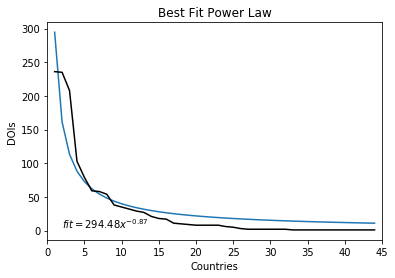

In [54]:
test = iswc_dois.sort_values(by=['paper_doi'], ascending=False)
test.insert(0, 'Rank', range(1, 1+len(test)))

x, y = test.Rank, test.paper_doi

powerlaw = lambda x, amp, index: amp * (x**index)

# define the fitting function
fitfunc = lambda p, x: p[0]*(x**p[1])
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0, 0.]
out = leastsq(errfunc, pinit, args=(x, y), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = pfinal[0]

plt.clf()
plt.subplot(1, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.plot(x, y, 'k')  # Data
plt.text(2, 4, '$fit = %5.2fx^{%5.2f}$' % (amp, index))
plt.title('Best Fit Power Law')
plt.xlabel('Countries')
plt.ylabel('DOIs')
plt.xlim(0, 45)

plt.show()

In [55]:
#Pareto check
data = iswc.groupby(['year', 'org_country'])['paper_doi'].nunique().reset_index().sort_values(by=['year', 'paper_doi'], ascending=[True, False])

for year in data.year.unique():
    year_data = data[data.year == year]
    n_countries = len(year_data.org_country)
    twenty_n_countries = int(round(0.2 * n_countries))
    n_papers = year_data.paper_doi.sum()
    eighty_n_papers = int(round(0.8 * n_papers))
    observed_n_papers = year_data[:twenty_n_countries].paper_doi.sum()
    is_pareto = True if observed_n_papers >= eighty_n_papers else False
    print('%s\t%s\t%s\t%s\t%s\t%s\t%s'% (year, n_papers, n_countries, twenty_n_countries, eighty_n_papers, observed_n_papers, is_pareto))

print('\n')
    
top_n = [3, 5, 10]
for n in top_n:
    previous = []
    coeffs = []
    p_vals = []
    rates_of_change = []
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
#             print('%s\n%s' % (previous.tolist(), current.tolist()))
            changes = len(previous) - len(set(previous) & set(current))
            rate_of_change = changes / len(previous)
#             print(rate_of_change)
            rates_of_change.append(rate_of_change)
            current_rank = []
            for c in current.tolist():
                if c in previous:
                    current_rank.append(previous.tolist().index(c) + 1)
                else:
                    current_rank.append(n+1)
            
            pearson = pearsonr(list(range(1, n+1)), current_rank)
            coeffs.append(pearson[0])
            p_vals.append(pearson[1])
#             print(list(range(1, n+1)), current_rank)
#             print('|---> ', pearson)
            previous = current
#     print(coeffs)
    print('Top-%s average similarity: %s (avg_p=%s)' % (n, sum(coeffs)/len(coeffs), sum(p_vals)/len(p_vals)))
#     print(rates_of_change)
    print('Top-%s average rate of change: %s' % (n, sum(rates_of_change)/len(rates_of_change)))

    
print('\n')

top_n = [3, 5, 10]
for n in top_n:
    previous = []
    country_counter = collections.Counter()
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(previous)
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(current)
            previous = current

    print('top-%s:' % n, len(country_counter), country_counter)

2003-01-01	64	15	3	51	41	False
2004-01-01	74	20	4	59	50	False
2005-01-01	85	18	4	68	52	False
2006-01-01	105	23	5	84	67	False
2007-01-01	101	20	4	81	55	False
2008-01-01	83	16	3	66	38	False
2009-01-01	85	17	3	68	45	False
2010-01-01	96	20	4	77	61	False
2011-01-01	106	20	4	85	59	False
2012-01-01	115	25	5	92	73	False
2013-01-01	104	20	4	83	69	False
2014-01-01	110	22	4	88	62	False
2015-01-01	109	24	5	87	65	False
2016-01-01	112	24	5	90	71	False


Top-3 average similarity: 0.15384615384615385 (avg_p=0.41025641025641024)
Top-3 average rate of change: 0.0
Top-5 average similarity: 0.8155099828237498 (avg_p=0.11741813880816565)
Top-5 average rate of change: 0.2153846153846154
Top-10 average similarity: 0.7749433255057278 (avg_p=0.019992793051986372)
Top-10 average rate of change: 0.23846153846153845


top-3: 3 Counter({'United States': 14, 'United Kingdom': 14, 'Germany': 14})
top-5: 11 Counter({'United States': 14, 'United Kingdom': 14, 'Germany': 14, 'Italy': 9, 'Netherlands': 6, 'China': 5, 'I

In [56]:
all_countries = set(iswc_dois['org_country'].unique().tolist())
first_countries = set(iswc_dois_first['org_country'].unique().tolist())
last_countries = set(iswc_dois_last['org_country'].unique().tolist())
all_countries - (first_countries | last_countries)

{'Egypt', 'Hong Kong'}

In [57]:
sorted = iswc_dois.sort_values(by=['paper_doi'], ascending=False)
print('Cutoff point: %s' % (0.2 * len(sorted)))
print('Top20: %s' % int(round(0.2 * len(sorted))))
print('Low80: %s' % (len(sorted) - int(round(0.2 * len(sorted)))))

top20 = sorted[:int(round(0.2 * len(sorted)))]['org_country'].tolist()
low80 = sorted[int(round(0.2 * len(sorted))):]['org_country'].tolist()
print(top20)
print(low80)

trend_top20 = iswc[iswc.org_country.isin(top20)].groupby(['year'])['paper_doi'].nunique()
trend_low80 = iswc[iswc.org_country.isin(low80)].groupby(['year'])['paper_doi'].nunique()

plotly.offline.iplot({
    "data": [{
        "x": trend_top20.index,
        "y": trend_top20.values,
        "name": 'top20'
    },
    {
        "x": trend_low80.index,
        "y": trend_low80.values,
        "name": 'low80'
    }],
    "layout": {
        "title": "[ISWC] DOIs top20 VS low80"
    }
})

Cutoff point: 8.8
Top20: 9
Low80: 35
['United States', 'Germany', 'United Kingdom', 'Italy', 'Netherlands', 'Ireland', 'China', 'France', 'Austria']
['Spain', 'Greece', 'Australia', 'Switzerland', 'Canada', 'Chile', 'Japan', 'Portugal', 'Belgium', 'Sweden', 'Czechia', 'Norway', 'Brazil', 'Finland', 'Venezuela', 'Singapore', 'India', 'New Zealand', 'South Korea', 'Turkey', 'Russia', 'Bulgaria', 'Ukraine', 'Thailand', 'Hong Kong', 'South Africa', 'Slovenia', 'Serbia', 'Denmark', 'Luxembourg', 'Egypt', 'Israel', 'Georgia', 'Indonesia', 'Vietnam']


In [58]:
data = iswc.groupby(['org_country', 'year'])['paper_doi'].nunique()
plotly.offline.iplot({
    "data": [{
        "x": data.xs(country, level='org_country').index,
        "y": data.xs(country, level='org_country').values,
        "name": country
    } for country in data.index.get_level_values('org_country').unique()],
    "layout": {
        "title": "[ISWC] DOIs by country"
    }
})

In [59]:
iswc_gridIds = iswc.groupby(['org_country'])['org_gridId'].nunique().reset_index()
iswc_gridIds_first = iswc_first.groupby(['org_country'])['org_gridId'].nunique().reset_index()
iswc_gridIds_last = iswc_last.groupby(['org_country'])['org_gridId'].nunique().reset_index()
fig = {
  "data": [
    {
        "values": iswc_gridIds['org_gridId'],
        "labels": iswc_gridIds['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, 1],
                    'y': [.4, 1]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },     
    {
        "values": iswc_gridIds_first['org_gridId'],
        "labels": iswc_gridIds_first['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, .5],
                    'y': [0, .6]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },
      {
        "values": iswc_gridIds_last['org_gridId'],
        "labels": iswc_gridIds_last['org_country'],
        "textposition":"inside",
        "domain": {'x': [.5, 1],
                    'y': [0, .6]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    }],
  "layout": {
        "title":"[ISWC] gridIDs breakdown by country",
        "annotations": [
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "All authors",
                "x": 0.50,
                "y": 1.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "1st authors",
                "x": .18,
                "y": -0.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "Last authors",
                "x": .83,
                "y": -0.07
            }
        ]
    }
}
plotly.offline.iplot(fig)

In [60]:
data = [
    go.Bar(
        x=iswc_gridIds.sort_values(by=['org_gridId'], ascending=False)['org_country'],
        y=iswc_gridIds.sort_values(by=['org_gridId'], ascending=False)['org_gridId']
    )
]

layout = go.Layout(
    title='[ISWC] gridIDs distribution',
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(b=100)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

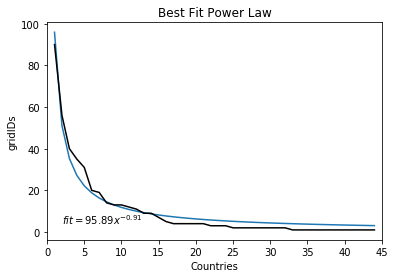

In [61]:
test = iswc_gridIds.sort_values(by=['org_gridId'], ascending=False)
test.insert(0, 'Rank', range(1, 1+len(test)))

x, y = test.Rank, test.org_gridId

powerlaw = lambda x, amp, index: amp * (x**index)

# define the fitting function
fitfunc = lambda p, x: p[0]*(x**p[1])
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0, 0.]
out = leastsq(errfunc, pinit, args=(x, y), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = pfinal[0]

plt.clf()
plt.subplot(1, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.plot(x, y, 'k')  # Data
plt.text(2, 4, '$fit = %5.2fx^{%5.2f}$' % (amp, index))
plt.title('Best Fit Power Law')
plt.xlabel('Countries')
plt.ylabel('gridIDs')
plt.xlim(0, 45)

plt.show()

In [62]:
data = iswc.groupby(['org_country', 'year'])['org_gridId'].nunique()
plotly.offline.iplot({
    "data": [{
        "x": data.xs(country, level='org_country').index,
        "y": data.xs(country, level='org_country').values,
        "name": country
    } for country in data.index.get_level_values('org_country').unique()],
    "layout": {
        "title": "[ISWC] gridIDs by country"
    }
})

## ESWC

### Preparation

ESWC 2007 apparently is missing!

In [63]:
df[df.book_doi == '10.1007/978-3-540-72667-8']

,paper_doi,conf_id,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year


In [64]:
eswc = df[(df.conf_seriesId == 'esws')]
eswc.to_csv('eswc_dump.csv')

In [65]:
eswc = read_csv('./eswc_enhanced.csv', dtype=object)
eswc['author_order'] = pd.to_numeric(eswc['author_order'])

In [66]:
eswc['conf_acronym'].unique()

array(['ESWC', 'ESWS'], dtype=object)

In [67]:
eswc_first = eswc[eswc.author_order == 1]
eswc_last_authors_idx = eswc.groupby('paper_doi')['author_order'].transform(max) == eswc['author_order']
eswc_last = eswc[eswc_last_authors_idx]

In [68]:
eswc.describe(include='all')

,paper_doi,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
count,4224,4224,4224,4224,4224,4224,4224.000000,4224,4224,4076,3931,3858,4083,4085,4224,4224,4224,4224,4224,3485,4224
unique,1141,1,2,4,8,5,NaN,1561,2176,511,467,293,54,54,961,1140,22,10,22,2,13
top,10.1007/978-3-642-41242-4_48,esws,ESWC,European Semantic Web Conference,"Heraklion, Crete",Greece,NaN,Andreas,Motta,grid.6142.1,"National University of Ireland, Galway",Karlsruhe,Germany,DE,The Open University,Optique: OBDA Solution for Big Data,10.1007/978-3-319-11955-7,The Semantic Web: Research and Applications,"ESWC 2014 Satellite Events, Anissaras, Crete, ...",OpenAccess,2015-01-01
freq,23,4224,4103,1899,1656,2646,NaN,45,21,133,133,150,939,939,123,23,334,1814,334,1787,630
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.826231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,2.228295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
eswc[eswc.conf_name == 'International Semantic Web Conference']

,paper_doi,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
9,10.1007/978-3-319-25639-9_10,esws,ESWC,International Semantic Web Conference,Portoro?,Slovenia,1,Giorgos,Giannopoulos,grid.19843.37,Athena Research and Innovation Center In Infor...,Marousi,Greece,GR,ATHENA Research Center,FAGI-gis: A Tool for Fusing Geospatial RDF Data,10.1007/978-3-319-25639-9,The Semantic Web: ESWC 2015 Satellite Events,"ESWC 2015 Satellite Events, Portoro?, Slovenia...",Restricted,2015-01-01
10,10.1007/978-3-319-25639-9_10,esws,ESWC,International Semantic Web Conference,Portoro?,Slovenia,2,Nick,Vitsas,grid.19843.37,Athena Research and Innovation Center In Infor...,Marousi,Greece,GR,ATHENA Research Center,FAGI-gis: A Tool for Fusing Geospatial RDF Data,10.1007/978-3-319-25639-9,The Semantic Web: ESWC 2015 Satellite Events,"ESWC 2015 Satellite Events, Portoro?, Slovenia...",Restricted,2015-01-01
11,10.1007/978-3-319-25639-9_10,esws,ESWC,International Semantic Web Conference,Portoro?,Slovenia,3,Nikos,Karagiannakis,grid.19843.37,Athena Research and Innovation Center In Infor...,Marousi,Greece,GR,ATHENA Research Center,FAGI-gis: A Tool for Fusing Geospatial RDF Data,10.1007/978-3-319-25639-9,The Semantic Web: ESWC 2015 Satellite Events,"ESWC 2015 Satellite Events, Portoro?, Slovenia...",Restricted,2015-01-01
12,10.1007/978-3-319-25639-9_10,esws,ESWC,International Semantic Web Conference,Portoro?,Slovenia,4,Dimitrios,Skoutas,grid.19843.37,Athena Research and Innovation Center In Infor...,Marousi,Greece,GR,ATHENA Research Center,FAGI-gis: A Tool for Fusing Geospatial RDF Data,10.1007/978-3-319-25639-9,The Semantic Web: ESWC 2015 Satellite Events,"ESWC 2015 Satellite Events, Portoro?, Slovenia...",Restricted,2015-01-01
13,10.1007/978-3-319-25639-9_10,esws,ESWC,International Semantic Web Conference,Portoro?,Slovenia,5,Spiros,Athanasiou,grid.19843.37,Athena Research and Innovation Center In Infor...,Marousi,Greece,GR,ATHENA Research Center,FAGI-gis: A Tool for Fusing Geospatial RDF Data,10.1007/978-3-319-25639-9,The Semantic Web: ESWC 2015 Satellite Events,"ESWC 2015 Satellite Events, Portoro?, Slovenia...",Restricted,2015-01-01
20,10.1007/978-3-319-34129-3_2,esws,ESWC,International Semantic Web Conference,Heraklion,Greece,1,Jacobo,Rouces,grid.5117.2,Aalborg University,Aalborg,Denmark,DK,Aalborg University,Heuristics for Connecting Heterogeneous Knowle...,10.1007/978-3-319-34129-3,The Semantic Web. Latest Advances and New Domains,"13th International Conference, ESWC 2016, Hera...",Restricted,2016-01-01
21,10.1007/978-3-319-34129-3_2,esws,ESWC,International Semantic Web Conference,Heraklion,Greece,3,Katja,Hose,grid.5117.2,Aalborg University,Aalborg,Denmark,DK,Aalborg University,Heuristics for Connecting Heterogeneous Knowle...,10.1007/978-3-319-34129-3,The Semantic Web. Latest Advances and New Domains,"13th International Conference, ESWC 2016, Hera...",Restricted,2016-01-01
27,10.1007/978-3-319-47602-5_5,esws,ESWC,International Semantic Web Conference,Heraklion,Greece,1,Kasper,Apajalahti,grid.5373.2,Aalto University,Helsinki,Finland,FI,Aalto University,StaRe: Statistical Reasoning Tool for 5G Netwo...,10.1007/978-3-319-47602-5,The Semantic Web,"ESWC 2016 Satellite Events, Heraklion, Crete, ...",Restricted,2016-01-01
28,10.1007/978-3-319-47602-5_5,esws,ESWC,International Semantic Web Conference,Heraklion,Greece,2,Eero,Hyvönen,grid.5373.2,Aalto University,Helsinki,Finland,FI,Aalto University,StaRe: Statistical Reasoning Tool for 5G Netwo...,10.1007/978-3-319-47602-5,The Semantic Web,"ESWC 2016 Satellite Events, Heraklion, Crete, ...",Restricted,2016-01-01
30,10.1007/978-3-319-34129-3_46,esws,ESWC,International Semantic Web Conference,Heraklion,Greece,1,Eero,Hyvönen,grid.5373.2,Aalto University,Helsinki,Finland,FI,Aalto University,WarSampo Data Service and Semantic P

In [70]:
eswc[eswc.paper_doi == '10.1007/978-3-540-68234-9_5']

,paper_doi,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
1473,10.1007/978-3-540-68234-9_5,esws,ESWC,European Semantic Web Conference,Canary Islands,Spain,2,Jörg,Unbehauen,grid.10211.33,Leuphana University,Lüneburg,Germany,DE,Leuphana - University of Lüneburg,xOperator – Interconnecting the Semantic Web a...,10.1007/978-3-540-68234-9,The Semantic Web: Research and Applications,"5th European Semantic Web Conference, ESWC 200...",OpenAccess,2008-01-01
2798,10.1007/978-3-540-68234-9_5,esws,ESWC,European Semantic Web Conference,Canary Islands,Spain,1,Sebastian,Dietzold,grid.9647.c,Leipzig University,Leipzig,Germany,DE,Universität Leipzig,xOperator – Interconnecting the Semantic Web a...,10.1007/978-3-540-68234-9,The Semantic Web: Research and Applications,"5th European Semantic Web Conference, ESWC 200...",OpenAccess,2008-01-01
2799,10.1007/978-3-540-68234-9_5,esws,ESWC,European Semantic Web Conference,Canary Islands,Spain,3,Sören,Auer,grid.9647.c,Leipzig University,Leipzig,Germany,DE,Universität Leipzig,xOperator – Interconnecting the Semantic Web a...,10.1007/978-3-540-68234-9,The Semantic Web: Research and Applications,"5th European Semantic Web Conference, ESWC 200...",OpenAccess,2008-01-01
3640,10.1007/978-3-540-68234-9_5,esws,ESWC,European Semantic Web Conference,Canary Islands,Spain,3,Sören,Auer,grid.25879.31,University of Pennsylvania,Philadelphia,United States,US,University of Pennsylvania,xOperator – Interconnecting the Semantic Web a...,10.1007/978-3-540-68234-9,The Semantic Web: Research and Applications,"5th European Semantic Web Conference, ESWC 200...",OpenAccess,2008-01-01


### Analysis

In [71]:
eswc_contributions = eswc.groupby(['year'])['paper_doi'].count()
eswc_contributions_with_gridId = eswc[eswc['org_gridId'].notna()].groupby(['year'])['paper_doi'].count()
eswc_contributions_without_gridId = eswc[eswc['org_gridId'].isna()].groupby(['year'])['paper_doi'].count()
plotly.offline.iplot({
"data": [{
    "x": eswc_contributions.index,
    "y": eswc_contributions.values,
    "name": "contributions",
    "marker": {"symbol": "circle"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_contributions_with_gridId.index,
    "y": eswc_contributions_with_gridId.values,
    "name": "contributions with gridID",
    "marker": {"symbol": "cross"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_contributions_without_gridId.index,
    "y": eswc_contributions_without_gridId.values,
    "name": "contributions without gridID",
    "marker": {"symbol": "triangle-up"},
    "mode": "lines+markers"
}],
"layout": {
    "title": "[ESWC] Trends of contributions",
    "legend": {"orientation": "h"},
    "font": {"size": 14}
}
})

In [72]:
eswc_ids = eswc.groupby(['year'])['paper_doi', 'org_gridId'].nunique()
plotly.offline.iplot({
"data": [{
    "x": eswc_ids.index,
    "y": eswc_ids['paper_doi'],
    "name": "DOIs",
    "marker": {"symbol": "circle"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_ids.index,
    "y": eswc_ids['org_gridId'],
    "name": "gridID",
    "marker": {"symbol": "cross"},
    "mode": "lines+markers"
}],
"layout": {
    "title": "[ESWC] Trends of unique identifiers",
    "legend": {"orientation": "h"},
    "font": {"size": 14}
}
})

In [73]:
eswc_gridId = eswc.groupby(['year'])['org_gridId'].nunique()
eswc_gridId_first = eswc_first.groupby(['year'])['org_gridId'].nunique()
eswc_gridId_last = eswc_last.groupby(['year'])['org_gridId'].nunique()
eswc_gridId_diff = eswc_gridId - pd.concat([eswc_gridId_first, eswc_gridId_last], axis=1).mean(axis=1)
plotly.offline.iplot({
"data": [
{ 
    "x": eswc_gridId.index,
    "y": eswc_gridId.values,
    "name": "gridIDs",
    "marker": {"symbol": "circle"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_gridId_first.index,
    "y": eswc_gridId_first.values,
    "name": "gridIDs (first authors)",
    "marker": {"symbol": "cross"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_gridId_last.index,
    "y": eswc_gridId_last.values,
    "name": "gridIDs (last authors)",
    "marker": {"symbol": "triangle-up"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_gridId_diff.index,
    "y": eswc_gridId_diff.values,
    "name": "differential trend",
    "mode": "lines"
}],
"layout": {
    "title": "[ESWC] gridIDs breakdown by author position",
     "legend": {"orientation": "h"},
    "font": {"size": 14}
}
})

In [74]:
eswc_excluded = set(eswc['org_gridId'].unique().tolist()) - (set(eswc_first['org_gridId'].unique().tolist()) | set(eswc_last['org_gridId'].unique().tolist()))
eswc[eswc.org_gridId.isin(eswc_excluded)][['paper_doi', 'org_gridId', 'org_name', 'org_country']].groupby(['org_country', 'org_gridId', 'org_name']).count()

paper_doi
org_country    org_gridId    org_name                                                     
Australia      grid.1003.2   University of Queensland                                    1
Austria        grid.22937.3d Medical University of Vienna                                1
               grid.432019.d Austrian Research Institute for Artificial Inte...          1
Belgium        grid.423619.b Centre d'Excellence en Technologies de l'Inform...          3
               grid.426419.c Space Applications Services (Belgium)                       1
Canada         grid.28046.38 University of Ottawa                                        1
Chile          grid.7870.8   Pontifical Catholic University of Chile                     2
China          grid.12527.33 Tsinghua University                                         2
               grid.412007.0 Nanchang Hangkong University                                1
               grid.412252.2 Northeastern University                                     1
Cuba           grid.441342.4 Polytechnic José Antonio Echeverría                         2
Egypt          grid.187323.c German University in Cairo                                  2
Finland        grid.13797.3b Åbo Akademi University                                      1
               grid.52593.38 Geological Survey of Finland                                1
               grid.8657.c   Finnish Meteorological Institute                            2
France         grid.425225.6 Internet Memory Foundation                                  1
               grid.4444.0   French National Centre for Scientific Research              1
               grid.460789.4 Université Paris-Saclay                                     1
               grid.460789.5 Université Paris-Saclay                                     1
               grid.460789.6 Université Paris-Saclay                                     1
               grid.460789.7 Université Paris-Saclay                                     1
               grid.460789.8 Université Paris-Saclay                                     1
               grid.469407.8 Centre de Physique Théorique                                1
Germany        grid.10211.33 Leuphana University                                         2
               grid.1957.a   RWTH Aachen University                                      7
               grid.424815.e IBM Germany                                                 1
               grid.449295.7 Baden-Wuerttemberg Cooperative State University             3
               grid.4562.5   University of Lubeck                                        1
               grid.461649.8 German National Library of Economics                        1
               grid.461823.a Steinbeis University Berlin                                 1
...                                                                                    ...
Romania        grid.8168.7   Alexandru Ioan Cuza University                              1
Russia         grid.77268.3c Kazan Federal University                                    1
Slovakia       grid.7960.8   University of Žilina                                        1
Spain          grid.10863.3c University of Oviedo                                        1
               grid.119375.8 Universidad Europea de Madrid                               1
               grid.424271.6 Vicomtech                                                   4
Sweden         grid.438506.c Tobii (Sweden)                                              1
United Kingdom grid.11918.30 University of Stirling                                      1
               grid.225360.0 European Bioinformatics Institute                           1
               grid.436766.6 Numerical Algorithms Group (United Kingdom)                 1
               grid.5846.f   University of Hertfordshire                                 1
               grid.7273.1   Aston University                                

In [75]:
iswc[iswc.org_gridId.isin(iswc_excluded & eswc_excluded)]['org_name'].unique()

array(['Center of Excellence For Research, Innovation, Education and industrial Labs partnerships',
       'European Bioinformatics Institute', 'German University in Cairo',
       'Istituto Superiore Mario Boella', 'San Jose State University'],
      dtype=object)

In [76]:
eswc_countries = eswc.groupby(['year'])['org_country'].nunique()
eswc_countries_first = eswc_first.groupby(['year'])['org_country'].nunique()
eswc_countries_last = eswc_last.groupby(['year'])['org_country'].nunique()
eswc_countries_diff = eswc_countries - pd.concat([eswc_countries_first, eswc_countries_last], axis=1).mean(axis=1)
plotly.offline.iplot({
"data": [
{ 
    "x": eswc_countries.index,
    "y": eswc_countries.values,
    "name": "countries",
    "marker": {"symbol": "circle"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_countries_first.index,
    "y": eswc_countries_first.values,
    "name": "countries (first authors)",
    "marker": {"symbol": "cross"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_countries_last.index,
    "y": eswc_countries_last.values,
    "name": "countries (last authors)",
    "marker": {"symbol": "triangle-up"},
    "mode": "lines+markers"
},
{ 
    "x": eswc_countries_diff.index,
    "y": eswc_countries_diff.values,
    "name": "differential trend",
    "mode": "lines"
}],
"layout": {
    "title": "[ESWC] Countries breakdown by author position",
     "legend": {"orientation": "h"},
    "font": {"size": 14}
}
})

In [77]:
eswc_dois = eswc.groupby(['org_country'])['paper_doi'].nunique().reset_index()
eswc_dois_first = eswc_first.groupby(['org_country'])['paper_doi'].nunique().reset_index()
eswc_dois_last = eswc_last.groupby(['org_country'])['paper_doi'].nunique().reset_index()
fig = {
  "data": [
    {
        "values": eswc_dois['paper_doi'],
        "labels": eswc_dois['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, 1],
                    'y': [.4, 1]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },     
    {
        "values": eswc_dois_first['paper_doi'],
        "labels": eswc_dois_first['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, .5],
                    'y': [0, .6]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },
    {
        "values": eswc_dois_last['paper_doi'],
        "labels": eswc_dois_last['org_country'],
        "textposition":"inside",
        "domain": {'x': [.5, 1],
                    'y': [0, .6]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    }],
  "layout": {
        "title":"[ESWC] DOIs breakdown by country",
        "annotations": [
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "All authors",
                "x": 0.50,
                "y": 1.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "1st authors",
                "x": .18,
                "y": -0.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "Last authors",
                "x": .83,
                "y": -0.07
            }
        ]
    }
}
plotly.offline.iplot(fig)

In [78]:
data = [
    go.Bar(
        x=eswc_dois.sort_values(by=['paper_doi'], ascending=False)['org_country'],
        y=eswc_dois.sort_values(by=['paper_doi'], ascending=False)['paper_doi']
    )
]

layout = go.Layout(
    title='[ESWC] Paper distribution',
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(b=100)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

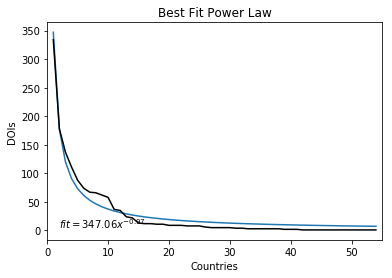

In [79]:
test = eswc_dois.sort_values(by=['paper_doi'], ascending=False)
test.insert(0, 'Rank', range(1, 1+len(test)))

x, y = test.Rank, test.paper_doi

powerlaw = lambda x, amp, index: amp * (x**index)

# define the fitting function
fitfunc = lambda p, x: p[0]*(x**p[1])
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0, 0.]
out = leastsq(errfunc, pinit, args=(x, y), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = pfinal[0]

plt.clf()
plt.subplot(1, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.plot(x, y, 'k')  # Data
plt.text(2, 4, '$fit = %5.2fx^{%5.2f}$' % (amp, index))
plt.title('Best Fit Power Law')
plt.xlabel('Countries')
plt.ylabel('DOIs')
plt.xlim(0, 55)

plt.show()

In [80]:
#Pareto check
data = eswc.groupby(['year', 'org_country'])['paper_doi'].nunique().reset_index().sort_values(by=['year', 'paper_doi'], ascending=[True, False])
for year in data.year.unique():
    year_data = data[data.year == year]
    n_countries = len(year_data.org_country)
    twenty_n_countries = int(round(0.2 * n_countries))
    n_papers = year_data.paper_doi.sum()
    eighty_n_papers = int(round(0.8 * n_papers))
    observed_n_papers = year_data[:twenty_n_countries].paper_doi.sum()
    is_pareto = True if observed_n_papers >= eighty_n_papers else False
    print('%s\t%s\t%s\t%s\t%s\t%s\t%s'% (year, n_papers, n_countries, twenty_n_countries, eighty_n_papers, observed_n_papers, is_pareto))

print('\n')
    
top_n = [3, 5, 10]
for n in top_n:
    previous = []
    coeffs = []
    p_vals = []
    rates_of_change = []
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
#             print('%s\n%s' % (previous.tolist(), current.tolist()))
            changes = len(previous) - len(set(previous) & set(current))
            rate_of_change = changes / len(previous)
#             print(rate_of_change)
            rates_of_change.append(rate_of_change)
            current_rank = []
            for c in current.tolist():
                if c in previous:
                    current_rank.append(previous.tolist().index(c) + 1)
                else:
                    current_rank.append(n+1)
            
            pearson = pearsonr(list(range(1, n+1)), current_rank)
            coeffs.append(pearson[0])
            p_vals.append(pearson[1])
#             print(list(range(1, n+1)), current_rank)
#             print('|---> ', pearson)
            
            previous = current
#     print(coeffs)
    print('Top-%s average similarity: %s (avg_p=%s)' % (n, sum(coeffs)/len(coeffs), sum(p_vals)/len(p_vals)))
#     print(rates_of_change)
    print('Top-%s average rate of change: %s' % (n, sum(rates_of_change)/len(rates_of_change)))

    
print('\n')

top_n = [3, 5, 10]
for n in top_n:
    previous = []
    country_counter = collections.Counter()
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(previous)
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(current)
            previous = current

    print('top-%s:' % n, len(country_counter), country_counter)

2004-01-01	40	18	4	32	23	False
2005-01-01	63	15	3	50	37	False
2006-01-01	70	16	3	56	38	False
2008-01-01	99	19	4	79	62	False
2009-01-01	107	20	4	86	68	False
2010-01-01	96	20	4	77	59	False
2011-01-01	95	24	5	76	57	False
2012-01-01	119	27	5	95	65	False
2013-01-01	152	26	5	122	90	False
2014-01-01	184	28	6	147	119	False
2015-01-01	220	35	7	176	142	False
2016-01-01	145	24	5	116	88	False
2017-01-01	84	22	4	67	48	False


Top-3 average similarity: 0.5904362729591852 (avg_p=0.39633384429831287)
Top-3 average rate of change: 0.3055555555555556
Top-5 average similarity: 0.6597948411514707 (avg_p=0.2583128103427966)
Top-5 average rate of change: 0.2833333333333334
Top-10 average similarity: 0.7305111231365203 (avg_p=0.030951964520734107)
Top-10 average rate of change: 0.225


top-3: 8 Counter({'Germany': 13, 'United Kingdom': 10, 'Italy': 5, 'France': 5, 'Austria': 2, 'United States': 2, 'Spain': 1, 'Greece': 1})
top-5: 11 Counter({'Germany': 13, 'United Kingdom': 12, 'Italy': 10, 'Spain': 5, 'Unit

In [81]:
all_countries = set(eswc_dois['org_country'].unique().tolist())
first_countries = set(eswc_dois_first['org_country'].unique().tolist())
last_countries = set(eswc_dois_last['org_country'].unique().tolist())
all_countries - (first_countries | last_countries)

{'Cuba', 'Egypt', 'Indonesia', 'Mali', 'Slovakia'}

In [82]:
eswc_gridIds = eswc.groupby(['org_country'])['org_gridId'].nunique().reset_index()
eswc_gridIds_first = eswc_first.groupby(['org_country'])['org_gridId'].nunique().reset_index()
eswc_gridIds_last = eswc_last.groupby(['org_country'])['org_gridId'].nunique().reset_index()
fig = {
  "data": [
    {
        "values": eswc_gridIds['org_gridId'],
        "labels": eswc_gridIds['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, 1],
                    'y': [.4, 1]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },     
    {
        "values": eswc_gridIds_first['org_gridId'],
        "labels": eswc_gridIds_first['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, .5],
                    'y': [0, .6]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },
      {
        "values": eswc_gridIds_last['org_gridId'],
        "labels": eswc_gridIds_last['org_country'],
        "textposition":"inside",
        "domain": {'x': [.5, 1],
                    'y': [0, .6]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    }],
  "layout": {
        "title":"[ESWC] gridIDs breakdown by country",
        "annotations": [
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "All authors",
                "x": 0.50,
                "y": 1.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "1st authors",
                "x": .18,
                "y": -0.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "Last authors",
                "x": .83,
                "y": -0.07
            }
        ]
    }
}
plotly.offline.iplot(fig)

In [83]:
data = [
    go.Bar(
        x=eswc_gridIds.sort_values(by=['org_gridId'], ascending=False)['org_country'],
        y=eswc_gridIds.sort_values(by=['org_gridId'], ascending=False)['org_gridId']
    )
]

layout = go.Layout(
    title='[ESWC] gridIDs distribution',
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(b=100)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

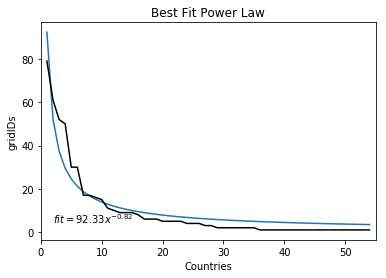

In [84]:
test = eswc_gridIds.sort_values(by=['org_gridId'], ascending=False)
test.insert(0, 'Rank', range(1, 1+len(test)))

x, y = test.Rank, test.org_gridId

powerlaw = lambda x, amp, index: amp * (x**index)

# define the fitting function
fitfunc = lambda p, x: p[0]*(x**p[1])
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0, 0.]
out = leastsq(errfunc, pinit, args=(x, y), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = pfinal[0]

plt.clf()
plt.subplot(1, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.plot(x, y, 'k')  # Data
plt.text(2, 4, '$fit = %5.2fx^{%5.2f}$' % (amp, index))
plt.title('Best Fit Power Law')
plt.xlabel('Countries')
plt.ylabel('gridIDs')
plt.xlim(0, 55)

plt.show()

# TPDL

## Preparation 

In [85]:
tpdl = df[(df.conf_seriesId == 'ercimdl') | (df.book_doi == '10.1007/978-3-319-24592-8')]
tpdl = tpdl.fillna({'conf_seriesId': 'ercimdl', 'conf_acronym': 'TPDL', 'conf_name': 'International Conference on Theory and Practice of Digital Libraries'})

tpdl.to_csv('tpdl_dump.csv')

In [86]:
tpdl = read_csv('./tpdl_enhanced.csv', dtype=object)
tpdl['author_order'] = pd.to_numeric(tpdl['author_order'])

In [87]:
tpdl['conf_acronym'].unique()

array(['TPDL', 'ECDL'], dtype=object)

In [88]:
tpdl_first = tpdl[tpdl.author_order == 1]
tpdl_last_authors_idx = tpdl.groupby('paper_doi')['author_order'].transform(max) == tpdl['author_order']
tpdl_last = tpdl[tpdl_last_authors_idx]

In [89]:
tpdl.describe(include='all')

,paper_doi,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
count,3271,3271,3271,3271,3271,3271,3271.000000,3271,3271,3208,3072,2991,3216,3216,3261,3271,3271,3271,3271,3168,3271
unique,919,1,2,1,14,11,NaN,1382,1736,485,441,280,52,52,867,893,16,3,15,2,15
top,10.1007/978-3-319-14226-5_4,ercimdl,ECDL,International Conference on Theory and Practic...,Valletta,Malta,NaN,Michael,Fox,grid.438526.e,Texas A&M University,Athens,United States,US,Virginia Tech,Understanding Climate Data Through Commentary ...,10.1007/978-3-642-15464-5,Research and Advanced Technology for Digital L...,"14th European Conference, ECDL 2010, Glasgow, ...",Restricted,2010-01-01
freq,23,3271,1981,3271,466,466,NaN,36,26,93,89,92,607,607,77,46,309,2835,309,3134,309
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.747784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,1.922260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
tpdl[tpdl.year == '2014-01-01']

,paper_doi,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
56,10.1007/978-3-319-08425-1_21,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,1,Sergiu,Gordea,grid.4332.6,Austrian Institute of Technology,Vienna,Austria,AT,AIT-Austrian Institute of Technology GmbH,An Image Similarity Search for the European Di...,10.1007/978-3-319-08425-1,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",NaN,2014-01-01
57,10.1007/978-3-319-14226-5_21,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,1,Sergiu,Gordea,grid.4332.6,Austrian Institute of Technology,Vienna,Austria,AT,AIT-Austrian Institute of Technology GmbH,An Image Similarity Search for the European Di...,10.1007/978-3-319-14226-5,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",Restricted,2014-01-01
295,10.1007/978-3-319-08425-1_23,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,1,Ingrid,Dillo,grid.418101.d,NaN,NaN,Netherlands,NL,Data Archiving and Networked Services,Training in Data Curation as Service in a Fede...,10.1007/978-3-319-08425-1,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",NaN,2014-01-01
296,10.1007/978-3-319-08425-1_23,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,2,Rene,Horik,grid.418101.d,NaN,NaN,Netherlands,NL,Data Archiving and Networked Services,Training in Data Curation as Service in a Fede...,10.1007/978-3-319-08425-1,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",NaN,2014-01-01
297,10.1007/978-3-319-08425-1_23,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,3,Andrea,Scharnhorst,grid.418101.d,NaN,NaN,Netherlands,NL,Data Archiving and Networked Services,Training in Data Curation as Service in a Fede...,10.1007/978-3-319-08425-1,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",NaN,2014-01-01
298,10.1007/978-3-319-14226-5_23,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,1,Ingrid,Dillo,grid.418101.d,NaN,NaN,Netherlands,NL,Data Archiving and Networked Services,Training in Data Curation as Service in a Fede...,10.1007/978-3-319-14226-5,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",Restricted,2014-01-01
299,10.1007/978-3-319-14226-5_23,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,2,Rene,Horik,grid.418101.d,NaN,NaN,Netherlands,NL,Data Archiving and Networked Services,Training in Data Curation as Service in a Fede...,10.1007/978-3-319-14226-5,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",Restricted,2014-01-01
300,10.1007/978-3-319-14226-5_23,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,3,Andrea,Scharnhorst,grid.418101.d,NaN,NaN,Netherlands,NL,Data Archiving and Networked Services,Training in Data Curation as Service in a Fede...,10.1007/978-3-319-14226-5,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",Restricted,2014-01-01
415,10.1007/978-3-319-08425-1_7,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,1,Nuno,Lopes,grid.454046.7,Digital Repository of Ireland,NaN,Ireland,IE,Digital Repository of Ireland,Linked Logainm: Enhancing Library Metadata Usi...,10.1007/978-3-319-08425-1,Theory and Practice of Digital Libraries -- TP...,"LCPD 2013, SUEDL 2013, DataCur 2013, Held in V...",NaN,2014-01-01
416,10.1007/978-3-319-08425-1_7,ercimdl,TPDL,International Conference on Theory and Practic

## Analysis

In [91]:
tpdl_contributions = tpdl.groupby(['year'])['paper_doi'].count()
tpdl_contributions_with_gridId = tpdl[tpdl['org_gridId'].notna()].groupby(['year'])['paper_doi'].count()
tpdl_contributions_without_gridId = tpdl[tpdl['org_gridId'].isna()].groupby(['year'])['paper_doi'].count()
plotly.offline.iplot({
"data": [{
    "x": tpdl_contributions.index,
    "y": tpdl_contributions.values,
    "name": "contributions",
    "marker": {"symbol": "circle"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_contributions_with_gridId.index,
    "y": tpdl_contributions_with_gridId.values,
    "name": "contributions with gridID",
    "marker": {"symbol": "cross"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_contributions_without_gridId.index,
    "y": tpdl_contributions_without_gridId.values,
    "name": "contributions without gridID",
    "marker": {"symbol": "triangle-up"},
    "mode": "lines+markers"
}],
"layout": {
    "title": "[TPDL] Trends of contributions",
     "legend": {"orientation": "h"},
    "font": {"size": 14}
}
})

In [92]:
tpdl_ids = tpdl.groupby(['year'])['paper_doi', 'org_gridId'].nunique()
plotly.offline.iplot({
"data": [{
    "x": tpdl_ids.index,
    "y": tpdl_ids['paper_doi'],
    "name": "DOIs",
    "marker": {"symbol": "circle"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_ids.index,
    "y": tpdl_ids['org_gridId'],
    "name": "gridID",
    "marker": {"symbol": "cross"},
    "mode": "lines+markers"
}],
"layout": {
    "title": "[TPDL] Trends of unique identifiers",
     "legend": {"orientation": "h"},
    "font": {"size": 14}
}
})

In [93]:
tpdl_gridId = tpdl.groupby(['year'])['org_gridId'].nunique()
tpdl_gridId_first = tpdl_first.groupby(['year'])['org_gridId'].nunique()
tpdl_gridId_last = tpdl_last.groupby(['year'])['org_gridId'].nunique()
tpdl_gridId_diff = tpdl_gridId - pd.concat([tpdl_gridId_first, tpdl_gridId_last], axis=1).mean(axis=1)
plotly.offline.iplot({
"data": [
{ 
    "x": tpdl_gridId.index,
    "y": tpdl_gridId.values,
    "name": "gridIDs",
    "marker": {"symbol": "circle"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_gridId_first.index,
    "y": tpdl_gridId_first.values,
    "name": "gridIDs (first authors)",
    "marker": {"symbol": "cross"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_gridId_last.index,
    "y": tpdl_gridId_last.values,
    "name": "gridIDs (last authors)",
    "marker": {"symbol": "triangle-up"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_gridId_diff.index,
    "y": tpdl_gridId_diff.values,
    "name": "differential trend",
    "mode": "lines"
}],
"layout": {
    "title": "[TPDL] gridIDs breakdown by author position",
     "legend": {"orientation": "h"},
    "font": {"size": 14}
}
})

In [94]:
tpdl_excluded = set(tpdl['org_gridId'].unique().tolist()) - (set(tpdl_first['org_gridId'].unique().tolist()) | set(tpdl_last['org_gridId'].unique().tolist()))
tpdl[tpdl.org_gridId.isin(tpdl_excluded)][['paper_doi', 'org_gridId', 'org_name', 'org_country']].groupby(['org_country', 'org_gridId', 'org_name']).count()

paper_doi
org_country    org_gridId    org_name                                                     
Austria        grid.426076.1 Austrian National Library                                   2
Belgium        grid.450763.3 European Cooperation in Science and Technology              1
               grid.4861.b   University of Liège                                         1
Brazil         grid.411181.c Federal University of Amazonas                              1
Canada         grid.143640.4 University of Victoria                                      1
               grid.17063.33 University of Toronto                                       1
               grid.267756.7 Vancouver Island University                                 1
China          grid.nec      NEC Laboratories China                                      1
Croatia        grid.424739.f University of Zadar                                         1
France         grid.412043.0 Université de Caen Basse-Normandie                          1
Germany        grid.424195.f Deutsches Archäologisches Institut                          1
               grid.449475.f RheinMain University of Applied Sciences                    1
               grid.5252.0   Ludwig-Maximilians-University                               1
Greece         grid.11047.33 University of Patras                                        2
               grid.15823.3d Harokopio University                                        1
               grid.226892.5 Athens Technology Center (Greece)                           3
               grid.410558.d University of Thessaly                                      2
               grid.436951.c Bank of Greece                                              1
               grid.veria    Veria Public Library                                        1
Hungary        grid.5591.8   Eötvös Loránd University                                    1
Ireland        grid.2bvds    National Library of Ireland                                 2
               grid.7886.1   University College Dublin                                   2
Italy          grid.424633.4 Alinari                                                     1
               grid.425647.6 Promoter (Italy)                                            1
               grid.7605.4   University of Turin                                         1
               grid.8158.4   University of Catania                                       3
Japan          grid.39158.36 Hokkaido University                                         2
Lithuania      grid.6441.7   Vilnius University                                          1
Netherlands    grid.419550.c Max Planck Institute for Psycholinguistics                  1
               grid.426566.5 European Grid Infrastructure                                1
...                                                                                    ...
Norway         grid.432487.e Avinet (Norway)                                             1
               grid.434364.2 Microsoft (Norway)                                          2
               grid.466171.3 Westerdals Oslo School of Arts, Communication a...          1
Portugal       grid.424495.a Caixa Mágica Software (Portugal)                            1
Slovenia       grid.17794.3c National and University Library, Turjaska 1, 10...          1
South Korea    grid.263333.4 Sejong University                                           2
               grid.267230.2 University of Suwon                                         1
Spain          grid.10863.3c University of Oviedo                                        2
               grid.424810.b Ikerbasque                                                  1
Sweden         grid.417839.0 Swedish Defence Research Agency                             1
               grid.6383.e   Swedish Institute of Computer Science                       2
Switzerland    grid.19739.35 Zurich University of Applied Sciences           

In [95]:
tpdl[tpdl.org_gridId.isin(tpdl_excluded & iswc_excluded)][['org_gridId', 'org_name']].drop_duplicates()

,org_gridId,org_name
136,grid.474329.f,British Geological Survey
1318,grid.94225.38,National Institute of Standards and Technology
2318,grid.6572.6,University of Birmingham


In [96]:
tpdl[tpdl.org_gridId == 'grid.425647.6']

,paper_doi,conf_seriesId,conf_acronym,conf_name,conf_city,conf_country,author_order,author_givenName,author_familyName,org_gridId,org_name,org_city,org_country,org_countrycode,affiliationString,paper_title,book_doi,book_title,book_confSubtitle,rights,year
1570,10.1007/978-3-642-40501-3_66,ercimdl,TPDL,International Conference on Theory and Practic...,Valletta,Malta,4,Antonella,Fresa,grid.425647.6,Promoter (Italy),Peccioli,Italy,IT,PROMOTER,e-Infrastructures for Digital Libraries…the Fu...,10.1007/978-3-642-40501-3,Research and Advanced Technology for Digital L...,International Conference on Theory and Practic...,Restricted,2013-01-01


In [97]:
tpdl_countries = tpdl.groupby(['year'])['org_country'].nunique()
tpdl_countries_first = tpdl_first.groupby(['year'])['org_country'].nunique()
tpdl_countries_last = tpdl_last.groupby(['year'])['org_country'].nunique()
tpdl_countries_diff = tpdl_countries - pd.concat([tpdl_countries_first, tpdl_countries_last], axis=1).mean(axis=1)
plotly.offline.iplot({
"data": [
{ 
    "x": tpdl_countries.index,
    "y": tpdl_countries.values,
    "name": "countries",
    "marker": {"symbol": "circle"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_countries_first.index,
    "y": tpdl_countries_first.values,
    "name": "countries (first authors)",
    "marker": {"symbol": "cross"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_countries_last.index,
    "y": tpdl_countries_last.values,
    "name": "countries (last authors)",
    "marker": {"symbol": "triangle-up"},
    "mode": "lines+markers"
},
{ 
    "x": tpdl_countries_diff.index,
    "y": tpdl_countries_diff.values,
    "name": "differential trend",
    "mode": "lines"
}],
"layout": {
    "title": "[TPDL] Countries breakdown by author position",
     "legend": {"orientation": "h"},
    "font": {"size": 14}
}
})

In [98]:
tpdl_dois = tpdl.groupby(['org_country'])['paper_doi'].nunique().reset_index()
tpdl_dois_first = tpdl_first.groupby(['org_country'])['paper_doi'].nunique().reset_index()
tpdl_dois_last = tpdl_last.groupby(['org_country'])['paper_doi'].nunique().reset_index()
fig = {
  "data": [
    {
        "values": tpdl_dois['paper_doi'],
        "labels": tpdl_dois['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, 1],
                    'y': [.4, 1]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },     
    {
        "values": tpdl_dois_first['paper_doi'],
        "labels": tpdl_dois_first['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, .5],
                    'y': [0, .6]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },
    {
        "values": tpdl_dois_last['paper_doi'],
        "labels": tpdl_dois_last['org_country'],
        "textposition":"inside",
        "domain": {'x': [.5, 1],
                    'y': [0, .6]},
        "name": "DOIs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    }],
  "layout": {
        "title":"[TPDL] DOIs breakdown by country",
        "annotations": [
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "All authors",
                "x": 0.50,
                "y": 1.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "1st authors",
                "x": .18,
                "y": -0.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "Last authors",
                "x": .83,
                "y": -0.07
            }
        ]
    }
}
plotly.offline.iplot(fig)

In [99]:
data = [
    go.Bar(
        x=tpdl_dois.sort_values(by=['paper_doi'], ascending=False)['org_country'],
        y=tpdl_dois.sort_values(by=['paper_doi'], ascending=False)['paper_doi']
    )
]

layout = go.Layout(
    title='[TPDL] Paper distribution',
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(b=100)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

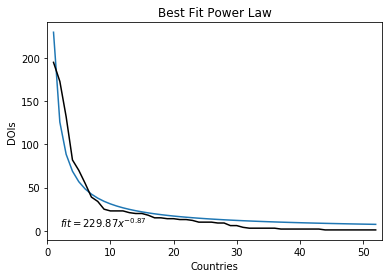

In [100]:
test = tpdl_dois.sort_values(by=['paper_doi'], ascending=False)
test.insert(0, 'Rank', range(1, 1+len(test)))

x, y = test.Rank, test.paper_doi

powerlaw = lambda x, amp, index: amp * (x**index)

# define the fitting function
fitfunc = lambda p, x: p[0]*(x**p[1])
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0, 0.]
out = leastsq(errfunc, pinit, args=(x, y), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = pfinal[0]

plt.clf()
plt.subplot(1, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.plot(x, y, 'k')  # Data
plt.text(2, 4, '$fit = %5.2fx^{%5.2f}$' % (amp, index))
plt.title('Best Fit Power Law')
plt.xlabel('Countries')
plt.ylabel('DOIs')
plt.xlim(0, 53)

plt.show()

In [101]:
#Pareto check
data = tpdl.groupby(['year', 'org_country'])['paper_doi'].nunique().reset_index().sort_values(by=['year', 'paper_doi'], ascending=[True, False])
for year in data.year.unique():
    year_data = data[data.year == year]
    n_countries = len(year_data.org_country)
    twenty_n_countries = int(round(0.2 * n_countries))
    n_papers = year_data.paper_doi.sum()
    eighty_n_papers = int(round(0.8 * n_papers))
    observed_n_papers = year_data[:twenty_n_countries].paper_doi.sum()
    is_pareto = True if observed_n_papers >= eighty_n_papers else False
    print('%s\t%s\t%s\t%s\t%s\t%s\t%s'% (year, n_papers, n_countries, twenty_n_countries, eighty_n_papers, observed_n_papers, is_pareto))

print('\n')
    
top_n = [3, 5, 10]
for n in top_n:
    previous = []
    coeffs = []
    p_vals = []
    rates_of_change = []
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
#             print('%s\n%s' % (previous.tolist(), current.tolist()))
            changes = len(previous) - len(set(previous) & set(current))
            rate_of_change = changes / len(previous)
#             print(rate_of_change)
            rates_of_change.append(rate_of_change)
            current_rank = []
            for c in current.tolist():
                if c in previous:
                    current_rank.append(previous.tolist().index(c) + 1)
                else:
                    current_rank.append(n+1)
            
            pearson = pearsonr(list(range(1, n+1)), current_rank)
            coeffs.append(pearson[0])
            p_vals.append(pearson[1])
#             print(list(range(1, n+1)), current_rank)
#             print('|---> ', pearson)
            
            previous = current
#     print(coeffs)
    print('Top-%s average similarity: %s (avg_p=%s)' % (n, sum(coeffs)/len(coeffs), sum(p_vals)/len(p_vals)))
#     print(rates_of_change)
    print('Top-%s average rate of change: %s' % (n, sum(rates_of_change)/len(rates_of_change)))

    
print('\n')

top_n = [3, 5, 10]
for n in top_n:
    previous = []
    country_counter = collections.Counter()
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(previous)
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(current)
            previous = current

    print('top-%s:' % n, len(country_counter), country_counter)

2003-01-01	53	18	4	42	37	False
2004-01-01	57	17	3	46	33	False
2005-01-01	90	27	5	72	53	False
2006-01-01	83	25	5	66	48	False
2007-01-01	92	26	5	74	53	False
2008-01-01	76	24	5	61	39	False
2009-01-01	91	25	5	73	57	False
2010-01-01	98	25	5	78	60	False
2011-01-01	86	28	6	69	48	False
2012-01-01	87	22	4	70	41	False
2013-01-01	106	27	5	85	63	False
2014-01-01	58	13	3	46	30	False
2015-01-01	37	17	3	30	14	False
2016-01-01	64	21	4	51	36	False
2017-01-01	73	24	5	58	47	False


Top-3 average similarity: 0.5197091381495905 (avg_p=0.28996854594824223)
Top-3 average rate of change: 0.3095238095238095
Top-5 average similarity: 0.655085644978979 (avg_p=0.253017644571723)
Top-5 average rate of change: 0.2285714285714286
Top-10 average similarity: 0.6987778819653977 (avg_p=0.06478934799727004)
Top-10 average rate of change: 0.3285714285714286


top-3: 7 Counter({'Germany': 14, 'United States': 12, 'United Kingdom': 9, 'Italy': 3, 'Greece': 3, 'Netherlands': 3, 'Brazil': 1})
top-5: 13 Counter({'Germany': 15,

In [102]:
all_countries = set(tpdl_dois['org_country'].unique().tolist())
first_countries = set(tpdl_dois_first['org_country'].unique().tolist())
last_countries = set(tpdl_dois_last['org_country'].unique().tolist())
all_countries - (first_countries | last_countries)

{'Croatia', 'Lithuania', 'Turkey'}

In [103]:
tpdl_gridIds = tpdl.groupby(['org_country'])['org_gridId'].nunique().reset_index()
tpdl_gridIds_first = tpdl_first.groupby(['org_country'])['org_gridId'].nunique().reset_index()
tpdl_gridIds_last = tpdl_last.groupby(['org_country'])['org_gridId'].nunique().reset_index()
fig = {
  "data": [
    {
        "values": tpdl_gridIds['org_gridId'],
        "labels": tpdl_gridIds['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, 1],
                    'y': [.4, 1]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },     
    {
        "values": tpdl_gridIds_first['org_gridId'],
        "labels": tpdl_gridIds_first['org_country'],
        "textposition":"inside",
        "domain": {'x': [0, .5],
                    'y': [0, .6]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    },
      {
        "values": tpdl_gridIds_last['org_gridId'],
        "labels": tpdl_gridIds_last['org_country'],
        "textposition":"inside",
        "domain": {'x': [.5, 1],
                    'y': [0, .6]},
        "name": "gridIDs",
        "hoverinfo":"label+value+name",
        "hole": .4,
        "type": "pie"
    }],
  "layout": {
        "title":"[TPDL] gridIDs breakdown by country",
        "annotations": [
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "All authors",
                "x": 0.50,
                "y": 1.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "1st authors",
                "x": .18,
                "y": -0.07
            },
            {
                "font": {
                    "size": 15
                },
                "showarrow": False,
                "text": "Last authors",
                "x": .83,
                "y": -0.07
            }
        ]
    }
}
plotly.offline.iplot(fig)

In [104]:
data = [
    go.Bar(
        x=tpdl_gridIds.sort_values(by=['org_gridId'], ascending=False)['org_country'],
        y=tpdl_gridIds.sort_values(by=['org_gridId'], ascending=False)['org_gridId']
    )
]

layout = go.Layout(
    title='[TPDL] gridIDs distribution',
    font=dict(size=14),
    xaxis=dict(tickangle=45),
    margin=dict(b=100)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

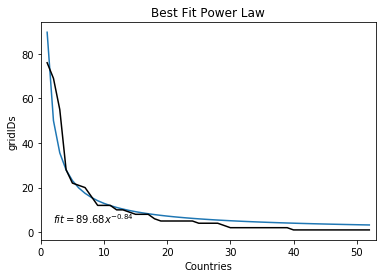

In [105]:
test = tpdl_gridIds.sort_values(by=['org_gridId'], ascending=False)
test.insert(0, 'Rank', range(1, 1+len(test)))

x, y = test.Rank, test.org_gridId

powerlaw = lambda x, amp, index: amp * (x**index)

# define the fitting function
fitfunc = lambda p, x: p[0]*(x**p[1])
errfunc = lambda p, x, y: (y - fitfunc(p, x))

pinit = [1.0, -1.0, 0.]
out = leastsq(errfunc, pinit, args=(x, y), full_output=1)

pfinal = out[0]
covar = out[1]

index = pfinal[1]
amp = pfinal[0]

plt.clf()
plt.subplot(1, 1, 1)
plt.plot(x, powerlaw(x, amp, index))     # Fit
plt.plot(x, y, 'k')  # Data
plt.text(2, 4, '$fit = %5.2fx^{%5.2f}$' % (amp, index))
plt.title('Best Fit Power Law')
plt.xlabel('Countries')
plt.ylabel('gridIDs')
plt.xlim(0, 53)

plt.show()

# Scratch pad

In [106]:
#Pareto check
data1 = iswc.groupby(['year', 'org_country'])['paper_doi'].nunique().reset_index().sort_values(by=['year', 'paper_doi'], ascending=[True, False])
data2 = eswc.groupby(['year', 'org_country'])['paper_doi'].nunique().reset_index().sort_values(by=['year', 'paper_doi'], ascending=[True, False])
data3 = tpdl.groupby(['year', 'org_country'])['paper_doi'].nunique().reset_index().sort_values(by=['year', 'paper_doi'], ascending=[True, False])
data = pd.concat([data1, data2, data3])
    
top_n = [3, 5, 10]
for n in top_n:
    previous = []
    coeffs = []
    p_vals = []
    rates_of_change = []
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
#             print('%s\n%s' % (previous.tolist(), current.tolist()))
            changes = len(previous) - len(set(previous) & set(current))
            rate_of_change = changes / len(previous)
#             print(rate_of_change)
            rates_of_change.append(rate_of_change)
            current_rank = []
            for c in current.tolist():
                if c in previous:
                    current_rank.append(previous.tolist().index(c) + 1)
                else:
                    current_rank.append(n+1)
            
            pearson = pearsonr(list(range(1, n+1)), current_rank)
            coeffs.append(pearson[0])
            p_vals.append(pearson[1])
#             print(list(range(1, n+1)), current_rank)
#             print('|---> ', pearson)
            previous = current
#     print(coeffs)
    print('Top-%s average similarity: %s (avg_p=%s)' % (n, sum(coeffs)/len(coeffs), sum(p_vals)/len(p_vals)))
#     print(rates_of_change)
    print('Top-%s average rate of change: %s' % (n, sum(rates_of_change)/len(rates_of_change)))

    
print('\n')

for n in top_n:
    previous = []
    country_counter = collections.Counter()
    for year in data.year.unique():
        year_data = data[data.year == year]
        if len(previous) == 0:
            previous = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(previous)
        else:
            current = year_data[:n].org_country.reset_index(drop=True).values
            country_counter.update(current)
            previous = current

    print('top-%s:' % n, len(country_counter), country_counter)

Top-3 average similarity: 0.2129986075758547 (avg_p=0.389597932261215)
Top-3 average rate of change: 0.023809523809523808
Top-5 average similarity: 0.792487624187487 (avg_p=0.1374968824792173)
Top-5 average rate of change: 0.21428571428571433
Top-10 average similarity: 0.7703523061495117 (avg_p=0.020082200128899802)
Top-10 average rate of change: 0.2357142857142857


top-3: 4 Counter({'United Kingdom': 15, 'Germany': 15, 'United States': 14, 'France': 1})
top-5: 11 Counter({'United States': 15, 'United Kingdom': 15, 'Germany': 15, 'Italy': 10, 'Netherlands': 6, 'China': 5, 'France': 3, 'Ireland': 3, 'Spain': 1, 'Greece': 1, 'Australia': 1})
top-10: 19 Counter({'United States': 15, 'United Kingdom': 15, 'Germany': 15, 'Italy': 15, 'Netherlands': 14, 'France': 13, 'Austria': 11, 'Ireland': 11, 'China': 9, 'Australia': 6, 'Greece': 6, 'Spain': 5, 'Canada': 4, 'Japan': 3, 'Switzerland': 3, 'Belgium': 2, 'Bulgaria': 1, 'Chile': 1, 'Norway': 1})


In [107]:
data = iswc.groupby(['org_country'])['paper_doi', 'org_gridId'].nunique().reset_index()
tmp = [ dict(
        type = 'choropleth',
        locationmode = 'country names',
        locations = data['org_country'],
        z = data['paper_doi'],
        text = data['org_country'],
#         colorscale = [[0,"rgb(0,0,0)"]],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = True,
            title = 'Title'),
      ) ]

layout = dict(
    title = '[ISWC] Paper distribution',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = dict(data=tmp, layout=layout)
plotly.offline.iplot( fig, validate=False )

In [108]:
data = df.groupby(['org_country', 'year'])['paper_doi'].nunique()
plotly.offline.iplot({
    "data": [{
        "x": data.xs(country, level='org_country').index,
        "y": data.xs(country, level='org_country').values,
        "name": country
    } for country in data.index.get_level_values('org_country').unique()],
    "layout": {
        "title": "DOIs by country"
    }
})

In [109]:
data = df.groupby(['org_country', 'year'])['org_gridId'].nunique()
plotly.offline.iplot({
    "data": [{
        "x": data.xs(country, level='org_country').index,
        "y": data.xs(country, level='org_country').values,
        "name": country
    } for country in data.index.get_level_values('org_country').unique()],
    "layout": {
        "title": "gridIDs by country"
    }
})